In [1]:
# импортируем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.base import clone
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     KFold)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, Trials, space_eval

# 1. hyperopt

In [2]:
# рассмотрим простой пример
best = fmin(
    fn=lambda x: x,
    space=hp.uniform('x', 0, 1),
    algo=tpe.suggest,
    max_evals=100,
    rstate=np.random.default_rng(123))
# печатаем результат
print(best)

100%|██████████| 100/100 [00:00<00:00, 636.95trial/s, best loss: 0.00010485226689373108]
{'x': 0.00010485226689373108}


In [3]:
# еще один пример
best = fmin(
    fn=lambda x: (x-1)**2,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100,
    rstate=np.random.default_rng(123))
print(best)

100%|██████████| 100/100 [00:00<00:00, 666.57trial/s, best loss: 0.00030214844882466425]
{'x': 1.0173824178072173}


In [4]:
# найдем такое значение х, которое минимизирует 
# квадратичную функцию у(х)=x**2

# задаем пространство поиска
fspace = {
    'x': hp.uniform('x', -5, 5)
}

# оптимизируемая функция
def objective(params):
    x = params['x']
    return x**2

# записываем историю
trials = Trials()

# выполняем оптимизацию
best = fmin(fn=objective, 
            space=fspace, 
            algo=tpe.suggest, 
            max_evals=1000, 
            trials=trials,
            rstate=np.random.default_rng(123))
print("best:", best)

100%|██████████| 1000/1000 [00:03<00:00, 300.40trial/s, best loss: 8.64144344431078e-07] 
best: {'x': 0.0009295936447884516}


In [5]:
# пространство поиска теперь можно задавать 
# и внутри оптимизируемой функции
def objective(x: hp.uniform('x', -5, 5)):
    return x**2

# записываем историю
trials = Trials()

# выполняем оптимизацию
best = fmin(
    fn=objective,
    space='annotated',
    algo=tpe.suggest, 
    max_evals=1000,
    trials=trials,
    rstate=np.random.default_rng(123))
print("best:", best)

100%|██████████| 1000/1000 [00:03<00:00, 324.25trial/s, best loss: 8.64144344431078e-07] 
best: {'x': 0.0009295936447884516}


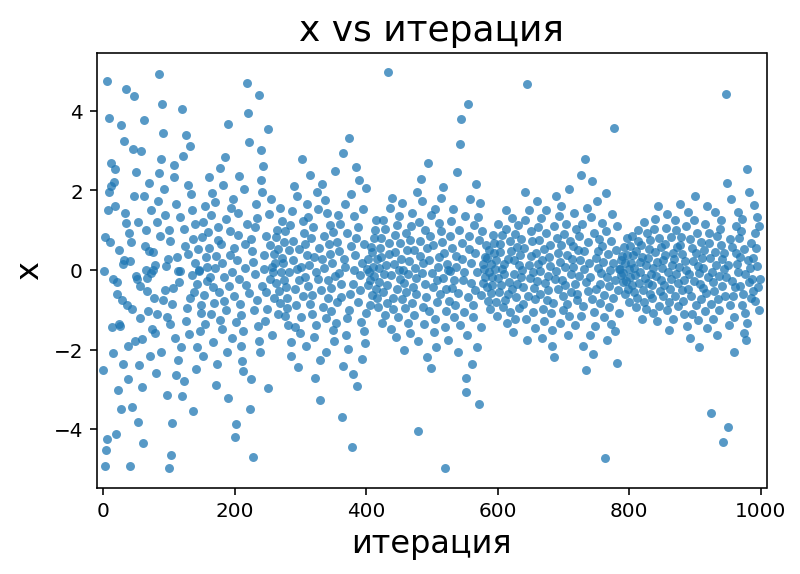

In [6]:
# визуализация значение аргумента vs итерация
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('x vs итерация', fontsize=18)
ax.set_xlabel('итерация', fontsize=16)
ax.set_ylabel('x', fontsize=16);

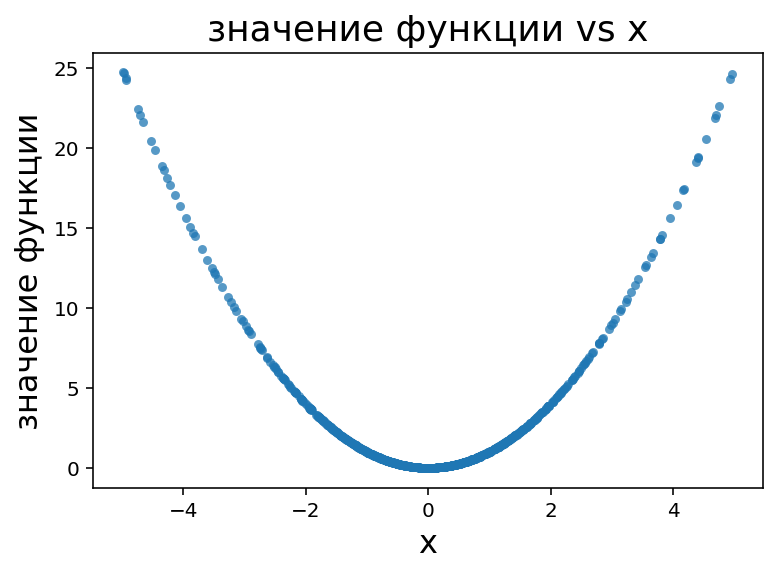

In [7]:
# визуализация значение функции vs значение аргумента
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('значение функции vs x', fontsize=18)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('значение функции', fontsize=16);

In [8]:
# загружаем уже знакомые данные
data = pd.read_csv('Data/StateFarm_missing.csv', sep=';')

In [9]:
# разбиваем данные на обучающие и тестовые: получаем обучающий
# массив признаков, тестовый массив признаков, обучающий массив
# меток, тестовый массив меток
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Response', axis=1), 
    data['Response'], 
    test_size=0.3,
    stratify=data['Response'],
    random_state=42)

In [10]:
# создаем списки категориальных 
# и количественных столбцов
cat_columns = X_train.select_dtypes(
    include='object').columns.tolist()
num_columns = X_train.select_dtypes(
    exclude='object').columns.tolist()

# создаем конвейер для количественных переменных
num_pipe = Pipeline([('imputer', SimpleImputer())])

# создаем конвейер для категориальных переменных
cat_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('ohe', OneHotEncoder(sparse=False, 
                          handle_unknown='ignore'))
])

# создаем список трехэлементных кортежей, в котором
# первый элемент кортежа - название конвейера с
# преобразованиями для определенного типа признаков
transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

# передаем список трансформеров в ColumnTransformer
transformer = ColumnTransformer(transformers=transformers)

# задаем итоговый конвейер
pipe = Pipeline([
    ('tr', transformer), 
    ('boost', GradientBoostingClassifier(random_state=42))
])

# создаем клон исходного итогового конвейера
initial_pipe = clone(pipe)

# взглянем на исходный итоговый конвейер
pipe

Pipeline(steps=[('tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer Lifetime Value',
                                                   'Income',
                                                   'Monthly Premium Auto',
                                                   'Months Since Last Claim',
                                                   'Months Since Policy '
                                                   'Inception',
                                                   'Number of Open Complaints',
                                                   'Number of Policies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Coverage', 'Education',
                                                   'EmploymentStatus',
                                                   'Gender'])])),
                ('boost', GradientBoostingClassifier(random_state=42))])

In [11]:
# пишем функцию, возвращающую правильность,
# усредненную по итогам перекрестной проверки
# (берем с минусом, т.к. максимизируем)
def hyperopt_objective(params):
    pipe.set_params(**params)
    return -cross_val_score(pipe, X_train, y_train, cv=5).mean()

# создаем пространство поиска
space_hyperopt = {
    'boost__learning_rate': hp.uniform(
        'boost__learning_rate', 0.001, 0.1),
    'tr__num__imputer__strategy': hp.choice(
        'tr__num__imputer__strategy', 
        ['mean', 'median', 'constant']),
    'tr__cat__imputer__strategy': hp.choice(
        'tr__cat__imputer__strategy', 
        ['most_frequent', 'constant'])
}

# записываем историю
trials = Trials()

# запускаем поиск
best = fmin(fn=hyperopt_objective, 
            space=space_hyperopt,
            algo=tpe.suggest, 
            max_evals=20,
            trials=trials,
            rstate=np.random.default_rng(123))

# печатаем результаты
print("best:")
print(best)

100%|██████████| 20/20 [00:49<00:00,  2.47s/trial, best loss: -0.9024978466838931]
best:
{'boost__learning_rate': 0.08228751341909112, 'tr__cat__imputer__strategy': 1, 'tr__num__imputer__strategy': 2}


In [12]:
# взглянем на конвейер, у него - гиперпараметры,
# присвоенные на последней, 20-й итерации
# оптимизации (итерации 19, нумерация с 0)
pipe

Pipeline(steps=[('tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Customer Lifetime Value',
                                                   'Income',
                                                   'Monthly Premium Auto',
                                                   'Months Since Last Claim',
                                                   'Months Since Policy '
                                                   'Inception',
                                                   'Number of Open Complaints',
                                                   'Number of Policies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Coverage', 'Education',
                                                   'EmploymentStatus',
                                                   'Gender'])])),
                ('boost',
                 GradientBoostingClassifier(learning_rate=0.06644185790225061,
                                            random_state=42))])

In [13]:
# посмотрим результаты оптимизации на итерации 19
trials.trials[19]

{'state': 2,
 'tid': 19,
 'spec': None,
 'result': {'loss': -0.9016365202411715, 'status': 'ok'},
 'misc': {'tid': 19,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'boost__learning_rate': [19],
   'tr__cat__imputer__strategy': [19],
   'tr__num__imputer__strategy': [19]},
  'vals': {'boost__learning_rate': [0.06644185790225061],
   'tr__cat__imputer__strategy': [0],
   'tr__num__imputer__strategy': [1]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 6, 27, 9, 45, 51, 663000),
 'refresh_time': datetime.datetime(2022, 6, 27, 9, 45, 54, 95000)}

In [14]:
# пишем функцию, вычисляющую правильность
# на тестовой выборке
def accuracy_tst(X_tr, y_tr, X_tst, y_tst, 
                 opt_results, space=None, 
                 optimize='optuna'):
    """
    Вычисляет правильность на тестовой выборке.
    
    Параметры
    ---------
    X_tr:
        Обучающий массив признаков.
    y_tr:
        Обучающий массив меток.
    X_tst:
        Тестовый массив признаков.
    y_tst:
        Тестовый массив меток.
    opt_results:
        Результаты оптимизации: 
        для hyperopt - результат, возвращаемый функцией fmin(),
        для optuna - study.best_trial.params.
    space:
        Пространство поиска (задается только для hyperopt).
    optimize:
        Способ оптимизации, возможные значения
        'optuna' и 'hyperopt'.
    """
    
    if space is None and optimize == 'hyperopt':
        raise ValueError('Задайте пространство поиска.')
        
    if space is not None and optimize == 'optuna':
        raise ValueError('Пространство поиска задается ' + 
                         'только для hyperopt.')
    
    if optimize == 'hyperopt':
        # записываем наилучшие значения гиперпараметров
        opt_results = space_eval(space, opt_results)
    
    # обучаем конвейер с наилучшими значениями
    # гиперпараметров на обучающей выборке
    pipe.set_params(**opt_results)
    pipe.fit(X_tr, y_tr)

    # вычисляем прогнозы на тестовой выборке
    test_predict = pipe.predict(X_tst)

    # вычисляем правильность для тестовой выборки
    return accuracy_score(y_tst, test_predict)

In [15]:
# вычислим правильность на тестовой выборке
accuracy_tst(X_train, y_train, X_test, y_test, 
             best, space=space_hyperopt, 
             optimize='hyperopt')

0.9031350482315113

In [16]:
# взглянем на конвейер, ему присвоены 
# оптимальные гиперпараметры
pipe

Pipeline(steps=[('tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['Customer Lifetime Value',
                                                   'Income',
                                                   'Monthly Premium Auto',
                                                   'Months Since Last Claim',
                                                   'Months Since Policy '
                                                   'Inception',
                                                   'Number of Open Complaints',
                                                   'Number of Policies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Coverage', 'Education',
                                                   'EmploymentStatus',
                                                   'Gender'])])),
                ('boost',
                 GradientBoostingClassifier(learning_rate=0.08228751341909112,
                                            random_state=42))])

# 2. skopt (scikit-optimize)

In [17]:
# импортируем класс BayesSearchCV, функцию gp_minimize()
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer

In [18]:
# найдем такое значение x, которое минимизирует 
# квадратичную функцию y(x)=(x-1)**2
best = gp_minimize(
    func=lambda x: (x[0] - 1) ** 2,
    dimensions=[Real(-2, 2)],
    n_calls=35,
    random_state=123)

# печатаем результат
print("наилучшее значение = %.4f" % best.fun)
print("x = %.4f" %best.x[0])

наилучшее значение = 0.0000
x = 0.9996


In [19]:
# создаем пространство поиска
space_skopt = {'boost__learning_rate': Real(0.001, 0.1, 
                                            prior='uniform'),
               'boost__max_depth': Integer(2, 8),
               'tr__num__imputer__strategy': Categorical(
                   ['mean', 'median', 'constant']),
               'tr__cat__imputer__strategy': Categorical(
                   ['most_frequent', 'constant'])}

In [20]:
# клонируем исходный итоговый конвейер
pipe = clone(initial_pipe)

# создаем экземпляр класса BayesSearchCV
opt = BayesSearchCV(pipe,
                    space_skopt,
                    n_iter=10,
                    scoring='accuracy',
                    random_state=42,
                    cv=5)
# запускаем поиск
opt.fit(X_train, y_train);

In [21]:
# смотрим наилучшее значение
print("Наилучшее значение правильности cv: %.3f" % opt.best_score_)
# смотрим наилучшие гиперпараметры
print("Наилучшие гиперпараметры:", 
      json.loads(json.dumps(opt.best_params_)))
# смотрим качество наилучшей модели на тестовой выборке
print("Правильность на тестовой выборке: %.3f" % opt.score(
    X_test, y_test))

Наилучшее значение правильности cv: 0.924
Наилучшие гиперпараметры: {'boost__learning_rate': 0.07366877378057127, 'boost__max_depth': 8, 'tr__cat__imputer__strategy': 'constant', 'tr__num__imputer__strategy': 'constant'}
Правильность на тестовой выборке: 0.933


In [22]:
# сохраняем результаты в датафрейм
results = pd.DataFrame(opt.cv_results_)
# избавляем от префикса param
results.columns = results.columns.str.replace('param_', '')
# превращаем в сводную таблицу
tbl = results.pivot_table(values=['mean_test_score'],    
                          index=['boost__learning_rate', 
                                 'boost__max_depth',
                                 'tr__cat__imputer__strategy',
                                 'tr__num__imputer__strategy'])
# сортируем по убыванию правильности
tbl = tbl.sort_values(by='mean_test_score', 
                      ascending=False)
tbl

,,,,mean_test_score
boost__learning_rate,boost__max_depth,tr__cat__imputer__strategy,tr__num__imputer__strategy,
0.073669,8,constant,constant,0.923686
0.083901,7,constant,median,0.921102
0.054797,8,constant,median,0.919552
0.045038,8,constant,mean,0.918174
0.095592,6,most_frequent,mean,0.917485
0.062091,7,constant,median,0.916968
0.080156,5,most_frequent,mean,0.907838
0.041600,6,most_frequent,mean,0.906977
0.081427,3,most_frequent,median,0.901292


In [23]:
# импортируем функцию use_named_args()
from skopt.utils import use_named_args

In [24]:
# задаем пространство поиска в ином формате
space_skopt2 = [
    Real(0.001, 0.1, name='boost__learning_rate', 
         prior='uniform'),
    Integer(2, 8, name='boost__max_depth'),
    Categorical(['mean', 'median', 'constant'], 
                name='tr__num__imputer__strategy'),
    Categorical(['most_frequent', 'constant'], 
                name='tr__cat__imputer__strategy')
]

In [25]:
# клонируем исходный итоговый конвейер
pipe = clone(initial_pipe)

# пишем функцию, возвращающую правильность,
# усредненную по итогам перекрестной проверки,
# и используем декоратор @use_named_args
@use_named_args(space_skopt2)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe,
                                    X_train,
                                    y_train,
                                    cv=5,
                                    n_jobs=-1))

In [26]:
# осуществляем поиск
res = gp_minimize(objective, 
                  space_skopt2, 
                  n_initial_points=5,
                  n_calls=10, 
                  random_state=42)

In [27]:
# смотрим наилучшее значение правильности
print("Наилучшее значение правильности: {:.4f}".format(
    np.abs(res.fun)))
# смотрим наилучшие гиперпараметры
pd.DataFrame({'boost__learning_rate': pd.Series(res.x[0]),
              'boost__max_depth': pd.Series(res.x[1]),
              'tr__num__imputer__strategy': pd.Series(res.x[2]),
              'tr__cat__imputer__strategy': pd.Series(res.x[3])})

Наилучшее значение правильности: 0.9306


,boost__learning_rate,boost__max_depth,tr__num__imputer__strategy,tr__cat__imputer__strategy
0,0.099916,8,mean,constant


# 3. optuna

In [28]:
# импортируем библиотеку optuna
import optuna
# импортируем класс TPESampler, задающий
# способ семплинга гиперпараметров
from optuna.samplers import TPESampler
# импортируем класс OptunaSearchCV
from optuna.integration import OptunaSearchCV
# импортируем классы, задающие форму 
# распределения значений гиперпараметров
from optuna.distributions import (IntUniformDistribution, 
                                  CategoricalDistribution, 
                                  UniformDistribution)

In [29]:
# задаем оптимизируемую функцию
def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    return (x - 2) ** 2

In [30]:
# создаем экземпляр класса TPESampler
sampler = TPESampler(seed=10)
# создаем объект study (сессию оптимизации)
study = optuna.create_study(sampler=sampler)
# выполняем оптимизацию
study.optimize(objective, n_trials=100)

[I 2022-06-27 12:47:13,772] A new study created in memory with name: no-name-dd895344-a34f-46b5-a141-112817ca4df5
[I 2022-06-27 12:47:13,773] Trial 0 finished with value: 11.740305123732652 and parameters: {'x': 5.426412865334919}. Best is trial 0 with value: 11.740305123732652.
[I 2022-06-27 12:47:13,774] Trial 1 finished with value: 134.21132166837336 and parameters: {'x': -9.58496101281197}. Best is trial 0 with value: 11.740305123732652.
[I 2022-06-27 12:47:13,775] Trial 2 finished with value: 0.45288148546152784 and parameters: {'x': 2.672964698525508}. Best is trial 2 with value: 0.45288148546152784.
[I 2022-06-27 12:47:13,776] Trial 3 finished with value: 8.857038183425992 and parameters: {'x': 4.976077650772236}. Best is trial 2 with value: 0.45288148546152784.
[I 2022-06-27 12:47:13,777] Trial 4 finished with value: 4.120330620698611 and parameters: {'x': -0.02985975394819107}. Best is trial 2 with value: 0.45288148546152784.
[I 2022-06-27 12:47:13,778] Trial 5 finished with v

[I 2022-06-27 12:47:13,927] Trial 45 finished with value: 12.651057188877942 and parameters: {'x': 5.556832465674753}. Best is trial 31 with value: 0.01705767032410098.
[I 2022-06-27 12:47:13,931] Trial 46 finished with value: 7.119136309311337 and parameters: {'x': -0.6681709670317861}. Best is trial 31 with value: 0.01705767032410098.
[I 2022-06-27 12:47:13,935] Trial 47 finished with value: 0.0004809479726091869 and parameters: {'x': 2.021930526044972}. Best is trial 47 with value: 0.0004809479726091869.
[I 2022-06-27 12:47:13,939] Trial 48 finished with value: 8.058321621688057 and parameters: {'x': 4.838718306152982}. Best is trial 47 with value: 0.0004809479726091869.
[I 2022-06-27 12:47:13,943] Trial 49 finished with value: 2.3582135073884984 and parameters: {'x': 0.46435241432531194}. Best is trial 47 with value: 0.0004809479726091869.
[I 2022-06-27 12:47:13,948] Trial 50 finished with value: 0.02422022604873272 and parameters: {'x': 2.155628487266094}. Best is trial 47 with va

[I 2022-06-27 12:47:14,130] Trial 90 finished with value: 0.005466039859712197 and parameters: {'x': 1.9260673288747647}. Best is trial 72 with value: 6.955116835403978e-07.
[I 2022-06-27 12:47:14,136] Trial 91 finished with value: 0.026701670370132248 and parameters: {'x': 1.8365935424466577}. Best is trial 72 with value: 6.955116835403978e-07.
[I 2022-06-27 12:47:14,142] Trial 92 finished with value: 0.5082959991875103 and parameters: {'x': 1.2870511945535568}. Best is trial 72 with value: 6.955116835403978e-07.
[I 2022-06-27 12:47:14,148] Trial 93 finished with value: 7.91233242229854 and parameters: {'x': 4.8128868484705425}. Best is trial 72 with value: 6.955116835403978e-07.
[I 2022-06-27 12:47:14,152] Trial 94 finished with value: 1.4366149948136113 and parameters: {'x': 0.8014112486704994}. Best is trial 72 with value: 6.955116835403978e-07.
[I 2022-06-27 12:47:14,157] Trial 95 finished with value: 5.1049056603904186e-05 and parameters: {'x': 2.0071448622522694}. Best is trial 

In [31]:
# выведем значение 𝑥, при котором было найдено 
# наилучшее значение целевой функции
print(study.best_params)
# выведем наилучшее значение целевой функции
print(study.best_value)
# выведем номер итерации, на которой было найдено 
# наилучшее значение целевой функции
print(study.best_trial)

{'x': 1.999166026569044}
6.955116835403978e-07
FrozenTrial(number=72, values=[6.955116835403978e-07], datetime_start=datetime.datetime(2022, 6, 27, 12, 47, 14, 37211), datetime_complete=datetime.datetime(2022, 6, 27, 12, 47, 14, 40652), params={'x': 1.999166026569044}, distributions={'x': UniformDistribution(high=10.0, low=-10.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=72, state=TrialState.COMPLETE, value=None)


In [32]:
# выводим результаты в виде датафрейма pandas
results_df = study.trials_dataframe(
    attrs=('number', 'value', 'params'))
results_df

,number,value,params_x
0,0,11.740305,5.426413
1,1,134.211322,-9.584961
2,2,0.452881,2.672965
3,3,8.857038,4.976078
4,4,4.120331,-0.029860
...,...,...,...
95,95,0.000051,2.007145
96,96,0.381294,2.617490
97,97,2.224550,3.491492
98,98,4.189630,4.046859


In [33]:
# создаем экземпляр класса KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# клонируем исходный итоговый конвейер
pipe = clone(initial_pipe)

# пишем функцию, которую будем оптимизировать
def objective(trial):
    # задаем пространство поиска
    params = {
        'boost__learning_rate': trial.suggest_uniform(
            'boost__learning_rate', 0.001, 0.1),
        'boost__max_depth': trial.suggest_int(
            'boost__max_depth', 2, 8),
        'tr__num__imputer__strategy': trial.suggest_categorical(
            'tr__num__imputer__strategy', ['mean', 'median', 'constant']),
        'tr__cat__imputer__strategy': trial.suggest_categorical(
            'tr__cat__imputer__strategy', ['most_frequent', 'constant'])
    }
    pipe.set_params(**params)
    return np.mean(cross_val_score(pipe, X_train, y_train, cv=kfold))

In [34]:
# создаем задачу оптимизации
study = optuna.create_study(sampler=sampler,
                            direction='maximize')
# отключаем вывод результатов оптимизации 
# в режиме реального времени
optuna.logging.disable_default_handler()
# выполняем оптимизацию
study.optimize(objective, n_trials=10)

[I 2022-06-27 12:47:14,257] A new study created in memory with name: no-name-2389ef3d-32c9-4a44-ae6f-7984073af0e2


In [35]:
# печатаем наилучшую правильность
best = study.best_trial
print("Наилучшая правильность cv: %.3f" % best.value)
print("Наилучшие гиперпараметры: ")
for key, value in best.params.items():
    print("  {}: {}".format(key, value))

Наилучшая правильность cv: 0.925
Наилучшие гиперпараметры: 
  boost__learning_rate: 0.06885062201841192
  boost__max_depth: 8
  tr__num__imputer__strategy: constant
  tr__cat__imputer__strategy: constant


In [36]:
# вычислим правильность на тестовой выборке
accuracy_tst(X_train, y_train, X_test, y_test, 
             best.params, space=None, 
             optimize='optuna')

0.9344855305466238

In [37]:
# задаем пространство поиска в немного ином формате
param_distributions = {
    'boost__learning_rate': UniformDistribution(0.001, 0.1),
    'boost__max_depth': IntUniformDistribution(2, 8),
    'tr__num__imputer__strategy': CategoricalDistribution(
        ['mean', 'median', 'constant']),
    'tr__cat__imputer__strategy': CategoricalDistribution(
        ['most_frequent', 'constant'])
}

# клонируем исходный итоговый конвейер
pipe = clone(initial_pipe)

# создаем экземпляр класса OptunaSearchCV
optuna_search = OptunaSearchCV(
    pipe,
    param_distributions,
    scoring='accuracy',
    random_state=42,
    n_trials=10,
    cv=kfold)

# выполняем оптимизацию
optuna_search.fit(X_train, y_train)

# печатаем наилучшие значения гиперпараметров
print("Наилучшие гиперпараметры:\n", 
      optuna_search.best_params_)
# печатаем наилучшее значение правильности
print("Наилучшая правильность cv: %.3f" % optuna_search.best_score_)
# печатаем правильность для тестовой выборки
test_score = optuna_search.score(X_test, y_test)
print("Правильность на тестовой выборке: %.3f" % test_score)

<ipython-input-37-6b976ae6f1d9>:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


Наилучшие гиперпараметры:
 {'boost__learning_rate': 0.0925232413252804, 'boost__max_depth': 8, 'tr__num__imputer__strategy': 'constant', 'tr__cat__imputer__strategy': 'most_frequent'}
Наилучшая правильность cv: 0.931
Правильность на тестовой выборке: 0.940


In [38]:
# модифицируем конвейер для работы с классом LGBMClassifier
lgbm_pipe = Pipeline([
    ('tr', transformer), 
    ('lgboost', LGBMClassifier(random_state=42, n_estimators=200))
])

# пишем оптимизируемую функцию
def lgbm_objective(trial):
    params = {
        'lgboost__learning_rate': trial.suggest_uniform(
            'lgboost__learning_rate', 0.001, 0.1),
        'lgboost__max_depth': trial.suggest_int(
            'lgboost__max_depth', 2, 8), 
        'tr__num__imputer__strategy': trial.suggest_categorical(
            'tr__num__imputer__strategy', ['mean', 'median', 'constant']),
        'tr__cat__imputer__strategy': trial.suggest_categorical(
            'tr__cat__imputer__strategy', ['most_frequent', 'constant'])
    }
    lgbm_pipe.set_params(**params)
    return np.mean(cross_val_score(lgbm_pipe, X_train, y_train, cv=5))

# создаем объект study (сессию оптимизации)
study = optuna.create_study(sampler=sampler, 
                            direction='maximize')

# выполняем оптимизацию
study.optimize(lgbm_objective, n_trials=10)

# печатаем результаты
print("Наилучшие гиперпараметры:\n", study.best_params)
print("Наилучшая правильность cv: %.3f" % study.best_value)

Наилучшие гиперпараметры:
 {'lgboost__learning_rate': 0.05264306808696978, 'lgboost__max_depth': 8, 'tr__num__imputer__strategy': 'mean', 'tr__cat__imputer__strategy': 'constant'}
Наилучшая правильность cv: 0.920


In [39]:
# импортируем подмодуль lightgbm модуля integration, 
# функцию early_stopping
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping

In [40]:
# выполняем Label Encoding
features = X_train.copy()
cols = list(features.columns[features.dtypes == 'object'])
for c in cols:
    features[c] = features[c].astype('category').cat.codes
# строковые метки зависимой переменной меняем на целочисленные
labels = np.where(y_train == 'Yes', 1, 0)
# формируем lgb.Dataset
dtrain = lgb.Dataset(data=features, label=labels)

In [41]:
# создаем словарь параметров и гиперпараметров
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt'
}

# создаем экземпляр класса LightGBMTunerCV
tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    num_boost_round=300,
    folds=KFold(n_splits=3, shuffle=True, random_state=42),
    callbacks=[early_stopping(30)],
    )

# запускаем оптимизацию
tuner.run()

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.672378 + 0.00518203
Training until validation scores don't improve for 30 rounds
[2]	cv_agg's auc: 0.697247 + 0.00639851
[3]	cv_agg's auc: 0.723532 + 0.00975531
[4]	cv_agg's auc: 0.744911 + 0.0177959
[5]	cv_agg's auc: 0.749059 + 0.015989
[6]	cv_agg's auc: 0.766411 + 0.0182292
[7]	cv_agg's auc: 0.777107 + 0.0232382
[8]	cv_agg's auc: 0.783745 + 0.0219775
[9]	cv_agg's auc: 0.789244 + 0.0224722
[10]	cv_agg's auc: 0.798119 + 0.0234791
[11]	cv_agg's auc: 0.803359 + 0.0275441
[12]	cv_agg's auc: 0.808759 + 0.0308316
[13]	cv_agg's auc: 0.813201 + 0.0311658
[14]	cv_agg's auc: 0.820977 + 0.0297445
[15]	cv_agg's auc: 0.826334 + 0.0317584
[16]	cv_agg's auc: 0.830439 + 0.031618
[17]	cv_agg's auc: 0.833143 + 0.032761
[18]	cv_agg's auc: 0.83481 + 0.0324616
[19]	cv_agg's auc: 0.835262 + 0.032374
[20]	cv_agg's auc: 0.837393 + 0.0339436
[21]	cv_agg's auc: 0.837316 + 0.0327979
[22]	cv_agg's auc: 0.839376 + 0.0319854
[23]	cv_agg's auc: 0.840537 + 0.0323785
[24]	cv_agg's auc: 0.841545 + 

feature_fraction, val_score: 0.897496:   0%|          | 0/7 [00:00<?, ?it/s]

[157]	cv_agg's auc: 0.896995 + 0.0200213
[158]	cv_agg's auc: 0.896841 + 0.0200719
[159]	cv_agg's auc: 0.896477 + 0.0199276
[160]	cv_agg's auc: 0.896611 + 0.0198473
[161]	cv_agg's auc: 0.89626 + 0.0196502
[162]	cv_agg's auc: 0.896063 + 0.0197903
[163]	cv_agg's auc: 0.896386 + 0.0196727
[164]	cv_agg's auc: 0.896188 + 0.01959
[165]	cv_agg's auc: 0.896017 + 0.0196976
Early stopping, best iteration is:
[135]	cv_agg's auc: 0.897496 + 0.0193679


feature_fraction, val_score: 0.897496:  14%|#4        | 1/7 [00:00<00:03,  1.58it/s]

[1]	cv_agg's auc: 0.671373 + 0.00438288
[2]	cv_agg's auc: 0.70911 + 0.0158647
[3]	cv_agg's auc: 0.728948 + 0.0194826
[4]	cv_agg's auc: 0.738624 + 0.0219501
[5]	cv_agg's auc: 0.756125 + 0.0246615
[6]	cv_agg's auc: 0.759426 + 0.0246345
[7]	cv_agg's auc: 0.767469 + 0.0254967
[8]	cv_agg's auc: 0.777045 + 0.0212729
[9]	cv_agg's auc: 0.783413 + 0.0274322
[10]	cv_agg's auc: 0.795481 + 0.0245673
[11]	cv_agg's auc: 0.800879 + 0.0277773
[12]	cv_agg's auc: 0.806383 + 0.0281812
[13]	cv_agg's auc: 0.815044 + 0.0307398
[14]	cv_agg's auc: 0.816743 + 0.0315141
[15]	cv_agg's auc: 0.819799 + 0.0320986
[16]	cv_agg's auc: 0.824949 + 0.0331413
[17]	cv_agg's auc: 0.82686 + 0.0351018
[18]	cv_agg's auc: 0.830401 + 0.0366795
[19]	cv_agg's auc: 0.834782 + 0.0364543
[20]	cv_agg's auc: 0.836308 + 0.0365413
[21]	cv_agg's auc: 0.839012 + 0.0364889
[22]	cv_agg's auc: 0.841774 + 0.0379929
[23]	cv_agg's auc: 0.845054 + 0.0383067
[24]	cv_agg's auc: 0.846183 + 0.0383314
[25]	cv_agg's auc: 0.84812 + 0.0372731
[26]	cv_agg

feature_fraction, val_score: 0.900116:  29%|##8       | 2/7 [00:01<00:03,  1.42it/s]

[185]	cv_agg's auc: 0.900116 + 0.0229407
[186]	cv_agg's auc: 0.90003 + 0.0224202
[187]	cv_agg's auc: 0.900029 + 0.0223716
[188]	cv_agg's auc: 0.899643 + 0.0226218
[189]	cv_agg's auc: 0.899973 + 0.0226737
[190]	cv_agg's auc: 0.900014 + 0.022648
[191]	cv_agg's auc: 0.899947 + 0.022891
[192]	cv_agg's auc: 0.899864 + 0.0231013
[193]	cv_agg's auc: 0.900015 + 0.0230516
[194]	cv_agg's auc: 0.899964 + 0.0231833
[195]	cv_agg's auc: 0.899903 + 0.0230647
[196]	cv_agg's auc: 0.900008 + 0.0230536
[197]	cv_agg's auc: 0.899822 + 0.0227859
[198]	cv_agg's auc: 0.899667 + 0.0226962
[199]	cv_agg's auc: 0.899557 + 0.0225189
[200]	cv_agg's auc: 0.899543 + 0.0227161
[201]	cv_agg's auc: 0.899447 + 0.0227588
[202]	cv_agg's auc: 0.899407 + 0.0225759
[203]	cv_agg's auc: 0.899431 + 0.0226583
[204]	cv_agg's auc: 0.899249 + 0.0226663
[205]	cv_agg's auc: 0.899237 + 0.0224868
[206]	cv_agg's auc: 0.899455 + 0.0227148
[207]	cv_agg's auc: 0.899417 + 0.0227898
[208]	cv_agg's auc: 0.899475 + 0.0228455
[209]	cv_agg's auc:

feature_fraction, val_score: 0.900116:  43%|####2     | 3/7 [00:01<00:02,  1.51it/s]

[181]	cv_agg's auc: 0.895726 + 0.0198481
[182]	cv_agg's auc: 0.895606 + 0.0200372
[183]	cv_agg's auc: 0.895531 + 0.019959
[184]	cv_agg's auc: 0.895412 + 0.0199964
[185]	cv_agg's auc: 0.895377 + 0.0198164
[186]	cv_agg's auc: 0.89509 + 0.0197326
[187]	cv_agg's auc: 0.894765 + 0.0193919
[188]	cv_agg's auc: 0.894801 + 0.0192297
[189]	cv_agg's auc: 0.894766 + 0.0194942
[190]	cv_agg's auc: 0.894999 + 0.0194024
[191]	cv_agg's auc: 0.895097 + 0.0195433
[192]	cv_agg's auc: 0.895246 + 0.0195004
[193]	cv_agg's auc: 0.895436 + 0.0195022
[194]	cv_agg's auc: 0.895158 + 0.0196158
[195]	cv_agg's auc: 0.895141 + 0.0195514
[196]	cv_agg's auc: 0.895286 + 0.0197439
[197]	cv_agg's auc: 0.895386 + 0.0195469
[198]	cv_agg's auc: 0.895065 + 0.019633
[199]	cv_agg's auc: 0.895115 + 0.0196014
[200]	cv_agg's auc: 0.894918 + 0.0194472
[201]	cv_agg's auc: 0.894648 + 0.0193155
[202]	cv_agg's auc: 0.894764 + 0.0194414
[203]	cv_agg's auc: 0.895028 + 0.0193185
[204]	cv_agg's auc: 0.895224 + 0.0191941
[205]	cv_agg's auc:

feature_fraction, val_score: 0.900116:  57%|#####7    | 4/7 [00:02<00:01,  1.53it/s]

[174]	cv_agg's auc: 0.897675 + 0.0193848
[175]	cv_agg's auc: 0.897771 + 0.0194103
[176]	cv_agg's auc: 0.897715 + 0.0193189
[177]	cv_agg's auc: 0.897617 + 0.0194192
[178]	cv_agg's auc: 0.897601 + 0.0197595
[179]	cv_agg's auc: 0.89777 + 0.0198283
[180]	cv_agg's auc: 0.897738 + 0.0195034
[181]	cv_agg's auc: 0.897863 + 0.0196475
[182]	cv_agg's auc: 0.897881 + 0.0194899
[183]	cv_agg's auc: 0.897937 + 0.0196571
[184]	cv_agg's auc: 0.897764 + 0.0198263
[185]	cv_agg's auc: 0.897718 + 0.0198692
[186]	cv_agg's auc: 0.89765 + 0.0198026
[187]	cv_agg's auc: 0.897634 + 0.0200505
[188]	cv_agg's auc: 0.897765 + 0.0200497
[189]	cv_agg's auc: 0.897737 + 0.0201035
[190]	cv_agg's auc: 0.897616 + 0.0202593
[191]	cv_agg's auc: 0.897662 + 0.0198817
[192]	cv_agg's auc: 0.897521 + 0.0202354
[193]	cv_agg's auc: 0.897298 + 0.0203287
[194]	cv_agg's auc: 0.897342 + 0.0203275
[195]	cv_agg's auc: 0.897248 + 0.0201045
[196]	cv_agg's auc: 0.897235 + 0.0202143
[197]	cv_agg's auc: 0.897059 + 0.0203256
[198]	cv_agg's auc

feature_fraction, val_score: 0.900116:  71%|#######1  | 5/7 [00:03<00:01,  1.52it/s]

[157]	cv_agg's auc: 0.89825 + 0.0226754
[158]	cv_agg's auc: 0.898084 + 0.022554
[159]	cv_agg's auc: 0.898438 + 0.022499
[160]	cv_agg's auc: 0.89841 + 0.0228962
[161]	cv_agg's auc: 0.898314 + 0.0231443
[162]	cv_agg's auc: 0.898509 + 0.0233006
[163]	cv_agg's auc: 0.898599 + 0.0231396
[164]	cv_agg's auc: 0.898548 + 0.023097
[165]	cv_agg's auc: 0.898737 + 0.0231087
[166]	cv_agg's auc: 0.898688 + 0.0228401
[167]	cv_agg's auc: 0.898587 + 0.0230858
[168]	cv_agg's auc: 0.898638 + 0.0228583
[169]	cv_agg's auc: 0.898612 + 0.0228275
[170]	cv_agg's auc: 0.898569 + 0.0227256
[171]	cv_agg's auc: 0.898668 + 0.0227506
[172]	cv_agg's auc: 0.89854 + 0.0228866
[173]	cv_agg's auc: 0.898577 + 0.0228495
[174]	cv_agg's auc: 0.898606 + 0.0227398
[175]	cv_agg's auc: 0.898362 + 0.0225404
[176]	cv_agg's auc: 0.898321 + 0.0223054
[177]	cv_agg's auc: 0.89838 + 0.0224573
[178]	cv_agg's auc: 0.898213 + 0.0225027
[179]	cv_agg's auc: 0.898336 + 0.0227253
[180]	cv_agg's auc: 0.898383 + 0.0229671
[181]	cv_agg's auc: 0.8

[147]	cv_agg's auc: 0.895406 + 0.0224535
[148]	cv_agg's auc: 0.895894 + 0.0223988


feature_fraction, val_score: 0.900116:  86%|########5 | 6/7 [00:03<00:00,  1.53it/s]

[149]	cv_agg's auc: 0.895814 + 0.0219754
[150]	cv_agg's auc: 0.895991 + 0.0216669
[151]	cv_agg's auc: 0.896389 + 0.0215908
[152]	cv_agg's auc: 0.896329 + 0.0216594
[153]	cv_agg's auc: 0.896367 + 0.0214437
[154]	cv_agg's auc: 0.896429 + 0.0215927
[155]	cv_agg's auc: 0.896394 + 0.0215557
[156]	cv_agg's auc: 0.896245 + 0.0217754
[157]	cv_agg's auc: 0.896349 + 0.0218179
[158]	cv_agg's auc: 0.896557 + 0.0217711
[159]	cv_agg's auc: 0.896602 + 0.0217585
[160]	cv_agg's auc: 0.896993 + 0.021587
[161]	cv_agg's auc: 0.897007 + 0.0215286
[162]	cv_agg's auc: 0.897073 + 0.021462
[163]	cv_agg's auc: 0.897337 + 0.0214499
[164]	cv_agg's auc: 0.897489 + 0.0215339
[165]	cv_agg's auc: 0.89758 + 0.0214994
[166]	cv_agg's auc: 0.897644 + 0.0212043
[167]	cv_agg's auc: 0.897603 + 0.0210826
[168]	cv_agg's auc: 0.897563 + 0.0211113
[169]	cv_agg's auc: 0.897662 + 0.0208548
[170]	cv_agg's auc: 0.897557 + 0.0210522
[171]	cv_agg's auc: 0.897611 + 0.0210296
[172]	cv_agg's auc: 0.897729 + 0.0210012
[173]	cv_agg's auc:

[197]	cv_agg's auc: 0.899896 + 0.017366


feature_fraction, val_score: 0.900590: 100%|##########| 7/7 [00:04<00:00,  1.50it/s]


[198]	cv_agg's auc: 0.900195 + 0.0173249
[199]	cv_agg's auc: 0.900409 + 0.0173256
[200]	cv_agg's auc: 0.900341 + 0.0174725
[201]	cv_agg's auc: 0.900415 + 0.0174519
[202]	cv_agg's auc: 0.900344 + 0.0175463
[203]	cv_agg's auc: 0.900247 + 0.0173697
[204]	cv_agg's auc: 0.90007 + 0.0173407
[205]	cv_agg's auc: 0.900162 + 0.0172897
[206]	cv_agg's auc: 0.900185 + 0.0173991
[207]	cv_agg's auc: 0.900116 + 0.017381
[208]	cv_agg's auc: 0.900168 + 0.0174651
[209]	cv_agg's auc: 0.899877 + 0.0173666
[210]	cv_agg's auc: 0.899911 + 0.0172307
[211]	cv_agg's auc: 0.900071 + 0.0173366
[212]	cv_agg's auc: 0.900385 + 0.0172368
[213]	cv_agg's auc: 0.900359 + 0.0172849
[214]	cv_agg's auc: 0.900302 + 0.0171266
[215]	cv_agg's auc: 0.900277 + 0.0171804
[216]	cv_agg's auc: 0.900236 + 0.0173018
Early stopping, best iteration is:
[186]	cv_agg's auc: 0.90059 + 0.0175163


num_leaves, val_score: 0.900590:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.761513 + 0.0199269
[2]	cv_agg's auc: 0.7795 + 0.0144912
[3]	cv_agg's auc: 0.801392 + 0.0193304
[4]	cv_agg's auc: 0.812289 + 0.0179157
[5]	cv_agg's auc: 0.819438 + 0.0185885
[6]	cv_agg's auc: 0.825294 + 0.0208703
[7]	cv_agg's auc: 0.834224 + 0.0216859
[8]	cv_agg's auc: 0.839365 + 0.0228378
[9]	cv_agg's auc: 0.843614 + 0.0232266
[10]	cv_agg's auc: 0.847024 + 0.0244937
[11]	cv_agg's auc: 0.854361 + 0.0219898
[12]	cv_agg's auc: 0.85659 + 0.0210365
[13]	cv_agg's auc: 0.861304 + 0.0204981
[14]	cv_agg's auc: 0.863721 + 0.0212372
[15]	cv_agg's auc: 0.867152 + 0.0214073
[16]	cv_agg's auc: 0.868431 + 0.0221188
[17]	cv_agg's auc: 0.872322 + 0.0211718
[18]	cv_agg's auc: 0.874551 + 0.0208383
[19]	cv_agg's auc: 0.877745 + 0.020995
[20]	cv_agg's auc: 0.879229 + 0.0218975
[21]	cv_agg's auc: 0.880639 + 0.0221884
[22]	cv_agg's auc: 0.883254 + 0.022348
[23]	cv_agg's auc: 0.883754 + 0.0226741
[24]	cv_agg's auc: 0.88455 + 0.0226728
[25]	cv_agg's auc: 0.886002 + 0.0225212
[26]	cv_agg's a

num_leaves, val_score: 0.900590:   5%|5         | 1/20 [00:01<00:26,  1.40s/it]

[205]	cv_agg's auc: 0.896149 + 0.0223866
[206]	cv_agg's auc: 0.896001 + 0.0224958
[207]	cv_agg's auc: 0.896022 + 0.0225398
[208]	cv_agg's auc: 0.895834 + 0.0225569
[209]	cv_agg's auc: 0.895906 + 0.0224197
[210]	cv_agg's auc: 0.895954 + 0.0222221
[211]	cv_agg's auc: 0.896019 + 0.0223121
[212]	cv_agg's auc: 0.896069 + 0.0223165
[213]	cv_agg's auc: 0.896132 + 0.0221121
[214]	cv_agg's auc: 0.896233 + 0.0221305
[215]	cv_agg's auc: 0.896334 + 0.0221631
[216]	cv_agg's auc: 0.896296 + 0.0224019
Early stopping, best iteration is:
[186]	cv_agg's auc: 0.90059 + 0.0175163
[1]	cv_agg's auc: 0.795114 + 0.0147719
[2]	cv_agg's auc: 0.806738 + 0.0160617
[3]	cv_agg's auc: 0.827153 + 0.0182659
[4]	cv_agg's auc: 0.834706 + 0.0189877
[5]	cv_agg's auc: 0.844541 + 0.0194754
[6]	cv_agg's auc: 0.849685 + 0.0202474
[7]	cv_agg's auc: 0.855638 + 0.0199335
[8]	cv_agg's auc: 0.859671 + 0.0208908
[9]	cv_agg's auc: 0.864573 + 0.0222058
[10]	cv_agg's auc: 0.866971 + 0.0226474
[11]	cv_agg's auc: 0.869486 + 0.0220814
[1

[204]	cv_agg's auc: 0.896617 + 0.0210261
[205]	cv_agg's auc: 0.896522 + 0.0208898
[206]	cv_agg's auc: 0.896509 + 0.0209965
[207]	cv_agg's auc: 0.896455 + 0.0209953
[208]	cv_agg's auc: 0.896487 + 0.0209057
[209]	cv_agg's auc: 0.896256 + 0.0211848
[210]	cv_agg's auc: 0.896167 + 0.0212721
[211]	cv_agg's auc: 0.896267 + 0.021196
[212]	cv_agg's auc: 0.896516 + 0.0213929
[213]	cv_agg's auc: 0.896484 + 0.0213515


num_leaves, val_score: 0.900590:  10%|#         | 2/20 [00:03<00:32,  1.83s/it]

[214]	cv_agg's auc: 0.896398 + 0.0215046
[215]	cv_agg's auc: 0.896312 + 0.0214702
[216]	cv_agg's auc: 0.89642 + 0.0212988
Early stopping, best iteration is:
[186]	cv_agg's auc: 0.90059 + 0.0175163
[1]	cv_agg's auc: 0.621863 + 0.0207161
[2]	cv_agg's auc: 0.639108 + 0.0253196
[3]	cv_agg's auc: 0.650401 + 0.0197175
[4]	cv_agg's auc: 0.653939 + 0.0214769
[5]	cv_agg's auc: 0.657351 + 0.0237247
[6]	cv_agg's auc: 0.659542 + 0.0205646
[7]	cv_agg's auc: 0.667488 + 0.0280258
[8]	cv_agg's auc: 0.674067 + 0.0258292
[9]	cv_agg's auc: 0.674345 + 0.0263378
[10]	cv_agg's auc: 0.677418 + 0.0287973
[11]	cv_agg's auc: 0.677472 + 0.0288002
[12]	cv_agg's auc: 0.677593 + 0.0282566
[13]	cv_agg's auc: 0.675906 + 0.0298626
[14]	cv_agg's auc: 0.680446 + 0.0281489
[15]	cv_agg's auc: 0.685578 + 0.0274351
[16]	cv_agg's auc: 0.684864 + 0.0280732
[17]	cv_agg's auc: 0.68806 + 0.0304016
[18]	cv_agg's auc: 0.690016 + 0.030465
[19]	cv_agg's auc: 0.690694 + 0.027218
[20]	cv_agg's auc: 0.691097 + 0.027516
[21]	cv_agg's au

num_leaves, val_score: 0.900590:  15%|#5        | 3/20 [00:03<00:19,  1.12s/it]

[142]	cv_agg's auc: 0.773871 + 0.0310125
[143]	cv_agg's auc: 0.773916 + 0.0316516
[144]	cv_agg's auc: 0.774512 + 0.0323719
[145]	cv_agg's auc: 0.77507 + 0.0322716
[146]	cv_agg's auc: 0.775694 + 0.0326857
[147]	cv_agg's auc: 0.776194 + 0.0323941
[148]	cv_agg's auc: 0.776466 + 0.0311004
[149]	cv_agg's auc: 0.776242 + 0.0307634
[150]	cv_agg's auc: 0.776642 + 0.0311006
[151]	cv_agg's auc: 0.776837 + 0.0314415
[152]	cv_agg's auc: 0.777026 + 0.0316952
[153]	cv_agg's auc: 0.776815 + 0.0312267
[154]	cv_agg's auc: 0.777278 + 0.0315873
[155]	cv_agg's auc: 0.777228 + 0.0311857
[156]	cv_agg's auc: 0.777488 + 0.0312399
[157]	cv_agg's auc: 0.777176 + 0.0317626
[158]	cv_agg's auc: 0.77761 + 0.0320497
[159]	cv_agg's auc: 0.777724 + 0.0324029
[160]	cv_agg's auc: 0.777809 + 0.0325905
[161]	cv_agg's auc: 0.778417 + 0.0325635
[162]	cv_agg's auc: 0.777895 + 0.0325892
[163]	cv_agg's auc: 0.778389 + 0.0329061
[164]	cv_agg's auc: 0.778627 + 0.0323751
[165]	cv_agg's auc: 0.778618 + 0.0324194
[166]	cv_agg's auc

[140]	cv_agg's auc: 0.899666 + 0.0204617
[141]	cv_agg's auc: 0.89942 + 0.0205829
[142]	cv_agg's auc: 0.899502 + 0.0208052
[143]	cv_agg's auc: 0.899779 + 0.0204638
[144]	cv_agg's auc: 0.899631 + 0.0205808
[145]	cv_agg's auc: 0.899452 + 0.0204385
[146]	cv_agg's auc: 0.899427 + 0.0203105
[147]	cv_agg's auc: 0.899794 + 0.0202099
[148]	cv_agg's auc: 0.899694 + 0.0201753
[149]	cv_agg's auc: 0.90021 + 0.0199711
[150]	cv_agg's auc: 0.900517 + 0.0198929
[151]	cv_agg's auc: 0.900808 + 0.0199169
[152]	cv_agg's auc: 0.900927 + 0.0200294
[153]	cv_agg's auc: 0.901117 + 0.0202367
[154]	cv_agg's auc: 0.901082 + 0.0202153
[155]	cv_agg's auc: 0.901079 + 0.0198462
[156]	cv_agg's auc: 0.901163 + 0.0196789
[157]	cv_agg's auc: 0.901483 + 0.0196714
[158]	cv_agg's auc: 0.901714 + 0.0195913
[159]	cv_agg's auc: 0.901792 + 0.0191987
[160]	cv_agg's auc: 0.901542 + 0.0196305
[161]	cv_agg's auc: 0.901758 + 0.0195294


num_leaves, val_score: 0.903109:  20%|##        | 4/20 [00:04<00:14,  1.07it/s]

[162]	cv_agg's auc: 0.901963 + 0.0196147
[163]	cv_agg's auc: 0.901997 + 0.0196038
[164]	cv_agg's auc: 0.902287 + 0.0196228
[165]	cv_agg's auc: 0.902605 + 0.0194171
[166]	cv_agg's auc: 0.9027 + 0.0192453
[167]	cv_agg's auc: 0.902709 + 0.0194634
[168]	cv_agg's auc: 0.902747 + 0.0195331
[169]	cv_agg's auc: 0.903109 + 0.0194964
[170]	cv_agg's auc: 0.902849 + 0.0195262
[171]	cv_agg's auc: 0.9028 + 0.0194528
[172]	cv_agg's auc: 0.902858 + 0.0194344
[173]	cv_agg's auc: 0.902679 + 0.019554
[174]	cv_agg's auc: 0.902734 + 0.0195969
[175]	cv_agg's auc: 0.902733 + 0.0196841
[176]	cv_agg's auc: 0.902489 + 0.0194852
[177]	cv_agg's auc: 0.902523 + 0.0195936
[178]	cv_agg's auc: 0.902337 + 0.019467
[179]	cv_agg's auc: 0.902451 + 0.0193715
[180]	cv_agg's auc: 0.902425 + 0.0194229
[181]	cv_agg's auc: 0.901917 + 0.0196337
[182]	cv_agg's auc: 0.902146 + 0.0196579
[183]	cv_agg's auc: 0.902292 + 0.01973
[184]	cv_agg's auc: 0.901927 + 0.0196932
[185]	cv_agg's auc: 0.901772 + 0.0198665
[186]	cv_agg's auc: 0.90

[169]	cv_agg's auc: 0.895361 + 0.020997
[170]	cv_agg's auc: 0.895443 + 0.0210393
[171]	cv_agg's auc: 0.895655 + 0.0211003
[172]	cv_agg's auc: 0.895823 + 0.0210378
[173]	cv_agg's auc: 0.896 + 0.0209577
[174]	cv_agg's auc: 0.895773 + 0.0210037
[175]	cv_agg's auc: 0.895817 + 0.0208769
[176]	cv_agg's auc: 0.895704 + 0.0208612
[177]	cv_agg's auc: 0.89589 + 0.0208702
[178]	cv_agg's auc: 0.896013 + 0.0207876
[179]	cv_agg's auc: 0.89599 + 0.0209306
[180]	cv_agg's auc: 0.896175 + 0.0207841
[181]	cv_agg's auc: 0.896352 + 0.0208921
[182]	cv_agg's auc: 0.896371 + 0.0209754
[183]	cv_agg's auc: 0.896271 + 0.0209789
[184]	cv_agg's auc: 0.896662 + 0.0206451
[185]	cv_agg's auc: 0.896826 + 0.0207319
[186]	cv_agg's auc: 0.896496 + 0.0206126
[187]	cv_agg's auc: 0.896445 + 0.0207828
[188]	cv_agg's auc: 0.896528 + 0.0208012
[189]	cv_agg's auc: 0.896396 + 0.0210862
[190]	cv_agg's auc: 0.896126 + 0.0213933
[191]	cv_agg's auc: 0.896331 + 0.0214493
[192]	cv_agg's auc: 0.896186 + 0.0215405
[193]	cv_agg's auc: 0.

num_leaves, val_score: 0.903109:  25%|##5       | 5/20 [00:06<00:18,  1.26s/it]

[197]	cv_agg's auc: 0.896075 + 0.0210867
[198]	cv_agg's auc: 0.896141 + 0.0211453
[199]	cv_agg's auc: 0.896194 + 0.0212518
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.795114 + 0.0147719
[2]	cv_agg's auc: 0.806738 + 0.0160617
[3]	cv_agg's auc: 0.827153 + 0.0182659
[4]	cv_agg's auc: 0.834706 + 0.0189877
[5]	cv_agg's auc: 0.844541 + 0.0194754
[6]	cv_agg's auc: 0.849685 + 0.0202474
[7]	cv_agg's auc: 0.855638 + 0.0199335
[8]	cv_agg's auc: 0.859671 + 0.0208908
[9]	cv_agg's auc: 0.864573 + 0.0222058
[10]	cv_agg's auc: 0.866971 + 0.0226474
[11]	cv_agg's auc: 0.869486 + 0.0220814
[12]	cv_agg's auc: 0.87248 + 0.0230339
[13]	cv_agg's auc: 0.874542 + 0.0236396
[14]	cv_agg's auc: 0.877542 + 0.023814
[15]	cv_agg's auc: 0.879093 + 0.0236344
[16]	cv_agg's auc: 0.881262 + 0.023114
[17]	cv_agg's auc: 0.883752 + 0.0233631
[18]	cv_agg's auc: 0.885661 + 0.0235539
[19]	cv_agg's auc: 0.886463 + 0.0247978
[20]	cv_agg's auc: 0.887404 + 0.0244653
[21]	cv_agg's

num_leaves, val_score: 0.903109:  30%|###       | 6/20 [00:08<00:20,  1.45s/it]

[185]	cv_agg's auc: 0.896826 + 0.0207319
[186]	cv_agg's auc: 0.896496 + 0.0206126
[187]	cv_agg's auc: 0.896445 + 0.0207828
[188]	cv_agg's auc: 0.896528 + 0.0208012
[189]	cv_agg's auc: 0.896396 + 0.0210862
[190]	cv_agg's auc: 0.896126 + 0.0213933
[191]	cv_agg's auc: 0.896331 + 0.0214493
[192]	cv_agg's auc: 0.896186 + 0.0215405
[193]	cv_agg's auc: 0.896466 + 0.0211347
[194]	cv_agg's auc: 0.896167 + 0.0210981
[195]	cv_agg's auc: 0.896164 + 0.0211262
[196]	cv_agg's auc: 0.896277 + 0.0211587
[197]	cv_agg's auc: 0.896075 + 0.0210867
[198]	cv_agg's auc: 0.896141 + 0.0211453
[199]	cv_agg's auc: 0.896194 + 0.0212518
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.795114 + 0.0147719
[2]	cv_agg's auc: 0.806738 + 0.0160617
[3]	cv_agg's auc: 0.827153 + 0.0182659
[4]	cv_agg's auc: 0.834706 + 0.0189877
[5]	cv_agg's auc: 0.844541 + 0.0194754
[6]	cv_agg's auc: 0.849685 + 0.0202474
[7]	cv_agg's auc: 0.855638 + 0.0199335
[8]	cv_agg's auc: 0.859671 + 0.02089

[190]	cv_agg's auc: 0.896126 + 0.0213933


num_leaves, val_score: 0.903109:  35%|###5      | 7/20 [00:10<00:20,  1.60s/it]

[191]	cv_agg's auc: 0.896331 + 0.0214493
[192]	cv_agg's auc: 0.896186 + 0.0215405
[193]	cv_agg's auc: 0.896466 + 0.0211347
[194]	cv_agg's auc: 0.896167 + 0.0210981
[195]	cv_agg's auc: 0.896164 + 0.0211262
[196]	cv_agg's auc: 0.896277 + 0.0211587
[197]	cv_agg's auc: 0.896075 + 0.0210867
[198]	cv_agg's auc: 0.896141 + 0.0211453
[199]	cv_agg's auc: 0.896194 + 0.0212518
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.695963 + 0.013725
[2]	cv_agg's auc: 0.724587 + 0.0188638
[3]	cv_agg's auc: 0.757988 + 0.0150363
[4]	cv_agg's auc: 0.772842 + 0.0116019
[5]	cv_agg's auc: 0.776697 + 0.0161925
[6]	cv_agg's auc: 0.783277 + 0.0210993
[7]	cv_agg's auc: 0.791929 + 0.0194558
[8]	cv_agg's auc: 0.796585 + 0.0202813
[9]	cv_agg's auc: 0.800695 + 0.02186
[10]	cv_agg's auc: 0.808018 + 0.0212092
[11]	cv_agg's auc: 0.812865 + 0.0219078
[12]	cv_agg's auc: 0.815457 + 0.022008
[13]	cv_agg's auc: 0.822081 + 0.0234042
[14]	cv_agg's auc: 0.825721 + 0.0233521
[15]	cv_

num_leaves, val_score: 0.903109:  40%|####      | 8/20 [00:10<00:15,  1.32s/it]

[151]	cv_agg's auc: 0.897937 + 0.01822
[152]	cv_agg's auc: 0.898242 + 0.0182036
[153]	cv_agg's auc: 0.898286 + 0.0179061
[154]	cv_agg's auc: 0.898357 + 0.0175407
[155]	cv_agg's auc: 0.8984 + 0.0173895
[156]	cv_agg's auc: 0.898421 + 0.0172279
[157]	cv_agg's auc: 0.89802 + 0.017395
[158]	cv_agg's auc: 0.898148 + 0.0173
[159]	cv_agg's auc: 0.898302 + 0.0171659
[160]	cv_agg's auc: 0.89827 + 0.0169393
[161]	cv_agg's auc: 0.898263 + 0.0168273
[162]	cv_agg's auc: 0.898444 + 0.0168963
[163]	cv_agg's auc: 0.89832 + 0.0170967
[164]	cv_agg's auc: 0.898415 + 0.016957
[165]	cv_agg's auc: 0.898325 + 0.0169874
[166]	cv_agg's auc: 0.898174 + 0.0171309
[167]	cv_agg's auc: 0.898129 + 0.017171
[168]	cv_agg's auc: 0.898193 + 0.0170807
[169]	cv_agg's auc: 0.898213 + 0.0170327
[170]	cv_agg's auc: 0.898233 + 0.017201
[171]	cv_agg's auc: 0.898202 + 0.0171138
[172]	cv_agg's auc: 0.898311 + 0.0170499
[173]	cv_agg's auc: 0.898152 + 0.017148
[174]	cv_agg's auc: 0.898189 + 0.0173615
[175]	cv_agg's auc: 0.898132 + 

[165]	cv_agg's auc: 0.897468 + 0.0200606
[166]	cv_agg's auc: 0.897622 + 0.0198775
[167]	cv_agg's auc: 0.897958 + 0.020093
[168]	cv_agg's auc: 0.897849 + 0.0199313
[169]	cv_agg's auc: 0.897787 + 0.0202272
[170]	cv_agg's auc: 0.897651 + 0.0204063
[171]	cv_agg's auc: 0.897696 + 0.0204944
[172]	cv_agg's auc: 0.897489 + 0.0205583
[173]	cv_agg's auc: 0.897026 + 0.0206949
[174]	cv_agg's auc: 0.896912 + 0.0208149
[175]	cv_agg's auc: 0.897043 + 0.0205258
[176]	cv_agg's auc: 0.897425 + 0.020454
[177]	cv_agg's auc: 0.897255 + 0.0205348
[178]	cv_agg's auc: 0.897066 + 0.0204988
[179]	cv_agg's auc: 0.896768 + 0.0204377
[180]	cv_agg's auc: 0.896913 + 0.0202343
[181]	cv_agg's auc: 0.896892 + 0.0201286
[182]	cv_agg's auc: 0.896912 + 0.020072
[183]	cv_agg's auc: 0.896568 + 0.0200428
[184]	cv_agg's auc: 0.896904 + 0.0199686
[185]	cv_agg's auc: 0.897121 + 0.020189
[186]	cv_agg's auc: 0.897264 + 0.020349
[187]	cv_agg's auc: 0.897511 + 0.0201323
[188]	cv_agg's auc: 0.897244 + 0.0200842
[189]	cv_agg's auc: 0

num_leaves, val_score: 0.903109:  45%|####5     | 9/20 [00:12<00:16,  1.49s/it]

[192]	cv_agg's auc: 0.896896 + 0.0200707
[193]	cv_agg's auc: 0.89687 + 0.0200444
[194]	cv_agg's auc: 0.897047 + 0.0196424
[195]	cv_agg's auc: 0.896877 + 0.0193504
[196]	cv_agg's auc: 0.896966 + 0.0192832
[197]	cv_agg's auc: 0.89676 + 0.0193146
[198]	cv_agg's auc: 0.896721 + 0.019495
[199]	cv_agg's auc: 0.896661 + 0.0195624
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.795114 + 0.0147719
[2]	cv_agg's auc: 0.806738 + 0.0160617
[3]	cv_agg's auc: 0.827153 + 0.0182659
[4]	cv_agg's auc: 0.834706 + 0.0189877
[5]	cv_agg's auc: 0.844541 + 0.0194754
[6]	cv_agg's auc: 0.849685 + 0.0202474
[7]	cv_agg's auc: 0.855638 + 0.0199335
[8]	cv_agg's auc: 0.859671 + 0.0208908
[9]	cv_agg's auc: 0.864573 + 0.0222058
[10]	cv_agg's auc: 0.866971 + 0.0226474
[11]	cv_agg's auc: 0.869486 + 0.0220814
[12]	cv_agg's auc: 0.87248 + 0.0230339
[13]	cv_agg's auc: 0.874542 + 0.0236396
[14]	cv_agg's auc: 0.877542 + 0.023814
[15]	cv_agg's auc: 0.879093 + 0.0236344
[16]	cv_ag

num_leaves, val_score: 0.903109:  50%|#####     | 10/20 [00:14<00:16,  1.61s/it]

[174]	cv_agg's auc: 0.895773 + 0.0210037
[175]	cv_agg's auc: 0.895817 + 0.0208769
[176]	cv_agg's auc: 0.895704 + 0.0208612
[177]	cv_agg's auc: 0.89589 + 0.0208702
[178]	cv_agg's auc: 0.896013 + 0.0207876
[179]	cv_agg's auc: 0.89599 + 0.0209306
[180]	cv_agg's auc: 0.896175 + 0.0207841
[181]	cv_agg's auc: 0.896352 + 0.0208921
[182]	cv_agg's auc: 0.896371 + 0.0209754
[183]	cv_agg's auc: 0.896271 + 0.0209789
[184]	cv_agg's auc: 0.896662 + 0.0206451
[185]	cv_agg's auc: 0.896826 + 0.0207319
[186]	cv_agg's auc: 0.896496 + 0.0206126
[187]	cv_agg's auc: 0.896445 + 0.0207828
[188]	cv_agg's auc: 0.896528 + 0.0208012
[189]	cv_agg's auc: 0.896396 + 0.0210862
[190]	cv_agg's auc: 0.896126 + 0.0213933
[191]	cv_agg's auc: 0.896331 + 0.0214493
[192]	cv_agg's auc: 0.896186 + 0.0215405
[193]	cv_agg's auc: 0.896466 + 0.0211347
[194]	cv_agg's auc: 0.896167 + 0.0210981
[195]	cv_agg's auc: 0.896164 + 0.0211262
[196]	cv_agg's auc: 0.896277 + 0.0211587
[197]	cv_agg's auc: 0.896075 + 0.0210867
[198]	cv_agg's auc

num_leaves, val_score: 0.903109:  55%|#####5    | 11/20 [00:15<00:14,  1.57s/it]

[181]	cv_agg's auc: 0.899726 + 0.0192177
[182]	cv_agg's auc: 0.8998 + 0.0190602
[183]	cv_agg's auc: 0.899617 + 0.019077
[184]	cv_agg's auc: 0.899667 + 0.0190785
[185]	cv_agg's auc: 0.899552 + 0.0190163
[186]	cv_agg's auc: 0.899658 + 0.0190267
[187]	cv_agg's auc: 0.899824 + 0.0187209
[188]	cv_agg's auc: 0.89999 + 0.0187434
[189]	cv_agg's auc: 0.899963 + 0.0185697
[190]	cv_agg's auc: 0.899744 + 0.0186781
[191]	cv_agg's auc: 0.899817 + 0.0185368
[192]	cv_agg's auc: 0.8996 + 0.0188641
[193]	cv_agg's auc: 0.899606 + 0.0188697
[194]	cv_agg's auc: 0.899479 + 0.0191892
[195]	cv_agg's auc: 0.899598 + 0.0191038
[196]	cv_agg's auc: 0.899401 + 0.0190005
[197]	cv_agg's auc: 0.899593 + 0.0187627
[198]	cv_agg's auc: 0.899594 + 0.0189148
[199]	cv_agg's auc: 0.899657 + 0.0187884
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.79359 + 0.011967
[2]	cv_agg's auc: 0.808143 + 0.00870558
[3]	cv_agg's auc: 0.823031 + 0.0149637
[4]	cv_agg's auc: 0.827786 + 0.0152

num_leaves, val_score: 0.903109:  60%|######    | 12/20 [00:17<00:11,  1.49s/it]

[172]	cv_agg's auc: 0.897269 + 0.0209002
[173]	cv_agg's auc: 0.896962 + 0.0206587
[174]	cv_agg's auc: 0.897254 + 0.0206116
[175]	cv_agg's auc: 0.896779 + 0.0208214
[176]	cv_agg's auc: 0.89643 + 0.0208701
[177]	cv_agg's auc: 0.896395 + 0.0208568
[178]	cv_agg's auc: 0.896654 + 0.0207056
[179]	cv_agg's auc: 0.896872 + 0.0205381
[180]	cv_agg's auc: 0.896912 + 0.0207164
[181]	cv_agg's auc: 0.896917 + 0.0209477
[182]	cv_agg's auc: 0.896873 + 0.0209002
[183]	cv_agg's auc: 0.89676 + 0.021127
[184]	cv_agg's auc: 0.896856 + 0.0209978
[185]	cv_agg's auc: 0.896844 + 0.0210104
[186]	cv_agg's auc: 0.896513 + 0.0210547
[187]	cv_agg's auc: 0.89641 + 0.021258
[188]	cv_agg's auc: 0.895953 + 0.0214529
[189]	cv_agg's auc: 0.895733 + 0.0214654
[190]	cv_agg's auc: 0.895573 + 0.0214444
[191]	cv_agg's auc: 0.895469 + 0.0215233
[192]	cv_agg's auc: 0.895472 + 0.0215542
[193]	cv_agg's auc: 0.895628 + 0.0214597
[194]	cv_agg's auc: 0.895659 + 0.0211995
[195]	cv_agg's auc: 0.895944 + 0.0211344
[196]	cv_agg's auc: 0

num_leaves, val_score: 0.903109:  65%|######5   | 13/20 [00:18<00:10,  1.47s/it]

[183]	cv_agg's auc: 0.896264 + 0.0221486
[184]	cv_agg's auc: 0.896176 + 0.0219563
[185]	cv_agg's auc: 0.896144 + 0.0219301
[186]	cv_agg's auc: 0.896199 + 0.0221292
[187]	cv_agg's auc: 0.89626 + 0.0222454
[188]	cv_agg's auc: 0.896229 + 0.022128
[189]	cv_agg's auc: 0.896378 + 0.0219885
[190]	cv_agg's auc: 0.89629 + 0.0218378
[191]	cv_agg's auc: 0.896529 + 0.0216943
[192]	cv_agg's auc: 0.896667 + 0.021801
[193]	cv_agg's auc: 0.896871 + 0.0216545
[194]	cv_agg's auc: 0.89684 + 0.0214008
[195]	cv_agg's auc: 0.896974 + 0.0211737
[196]	cv_agg's auc: 0.89704 + 0.0211871
[197]	cv_agg's auc: 0.897015 + 0.0211105
[198]	cv_agg's auc: 0.897037 + 0.0207788
[199]	cv_agg's auc: 0.897069 + 0.0207783
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.721409 + 0.00607818
[2]	cv_agg's auc: 0.746502 + 0.00623002
[3]	cv_agg's auc: 0.777728 + 0.00707079
[4]	cv_agg's auc: 0.792372 + 0.00725289
[5]	cv_agg's auc: 0.797416 + 0.0123486
[6]	cv_agg's auc: 0.802124 + 0.016

num_leaves, val_score: 0.903109:  70%|#######   | 14/20 [00:19<00:07,  1.29s/it]

[175]	cv_agg's auc: 0.900856 + 0.0202741
[176]	cv_agg's auc: 0.90075 + 0.0200562
[177]	cv_agg's auc: 0.900931 + 0.0199497
[178]	cv_agg's auc: 0.90084 + 0.0199352
[179]	cv_agg's auc: 0.900995 + 0.0201349
[180]	cv_agg's auc: 0.900658 + 0.0202922
[181]	cv_agg's auc: 0.900798 + 0.0202982
[182]	cv_agg's auc: 0.900676 + 0.0202479
[183]	cv_agg's auc: 0.900898 + 0.0202767
[184]	cv_agg's auc: 0.90098 + 0.0203624
[185]	cv_agg's auc: 0.901201 + 0.0204424
[186]	cv_agg's auc: 0.901106 + 0.0205716
[187]	cv_agg's auc: 0.901247 + 0.0205444
[188]	cv_agg's auc: 0.901182 + 0.020489
[189]	cv_agg's auc: 0.901193 + 0.0202127
[190]	cv_agg's auc: 0.901014 + 0.0201638
[191]	cv_agg's auc: 0.901207 + 0.0201572
[192]	cv_agg's auc: 0.901126 + 0.0202233
[193]	cv_agg's auc: 0.901215 + 0.0203097
[194]	cv_agg's auc: 0.901417 + 0.0202837
[195]	cv_agg's auc: 0.901267 + 0.0202947
[196]	cv_agg's auc: 0.901052 + 0.0204138
[197]	cv_agg's auc: 0.901023 + 0.0202679
[198]	cv_agg's auc: 0.901172 + 0.0201535
[199]	cv_agg's auc: 

num_leaves, val_score: 0.903109:  75%|#######5  | 15/20 [00:20<00:05,  1.13s/it]

[196]	cv_agg's auc: 0.89684 + 0.0212908
[197]	cv_agg's auc: 0.896852 + 0.0211015
[198]	cv_agg's auc: 0.896853 + 0.021262
[199]	cv_agg's auc: 0.89706 + 0.0211761
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.610799 + 0.0204253
[2]	cv_agg's auc: 0.624873 + 0.0222499
[3]	cv_agg's auc: 0.624873 + 0.0222499
[4]	cv_agg's auc: 0.631325 + 0.0223186
[5]	cv_agg's auc: 0.637562 + 0.0242135
[6]	cv_agg's auc: 0.63964 + 0.0229613
[7]	cv_agg's auc: 0.637173 + 0.0219646
[8]	cv_agg's auc: 0.643815 + 0.0193715
[9]	cv_agg's auc: 0.649974 + 0.0269342
[10]	cv_agg's auc: 0.651351 + 0.0274937
[11]	cv_agg's auc: 0.655537 + 0.0249125
[12]	cv_agg's auc: 0.663899 + 0.0236549
[13]	cv_agg's auc: 0.667424 + 0.0221287
[14]	cv_agg's auc: 0.669178 + 0.0277349
[15]	cv_agg's auc: 0.667164 + 0.0296115
[16]	cv_agg's auc: 0.667846 + 0.0278063
[17]	cv_agg's auc: 0.675244 + 0.02766
[18]	cv_agg's auc: 0.674053 + 0.0321963
[19]	cv_agg's auc: 0.675686 + 0.0312059
[20]	cv_agg's a

num_leaves, val_score: 0.903109:  80%|########  | 16/20 [00:20<00:03,  1.16it/s]

[133]	cv_agg's auc: 0.724113 + 0.0327923
[134]	cv_agg's auc: 0.724118 + 0.0329963
[135]	cv_agg's auc: 0.724131 + 0.0330359
[136]	cv_agg's auc: 0.724006 + 0.0323867
[137]	cv_agg's auc: 0.724441 + 0.0324711
[138]	cv_agg's auc: 0.724416 + 0.0318271
[139]	cv_agg's auc: 0.724748 + 0.0321407
[140]	cv_agg's auc: 0.725057 + 0.0325517
[141]	cv_agg's auc: 0.72535 + 0.0324618
[142]	cv_agg's auc: 0.725981 + 0.0315443
[143]	cv_agg's auc: 0.726511 + 0.0312574
[144]	cv_agg's auc: 0.72647 + 0.0312492
[145]	cv_agg's auc: 0.726834 + 0.0312543
[146]	cv_agg's auc: 0.727725 + 0.0318868
[147]	cv_agg's auc: 0.727663 + 0.0316303
[148]	cv_agg's auc: 0.727693 + 0.0312339
[149]	cv_agg's auc: 0.727823 + 0.0312744
[150]	cv_agg's auc: 0.728264 + 0.0318116
[151]	cv_agg's auc: 0.728808 + 0.0318624
[152]	cv_agg's auc: 0.729188 + 0.0312743
[153]	cv_agg's auc: 0.729846 + 0.030831
[154]	cv_agg's auc: 0.729596 + 0.030396
[155]	cv_agg's auc: 0.729844 + 0.0305517
[156]	cv_agg's auc: 0.730285 + 0.0302636
[157]	cv_agg's auc: 

[141]	cv_agg's auc: 0.897936 + 0.0202065
[142]	cv_agg's auc: 0.897772 + 0.0206516
[143]	cv_agg's auc: 0.897833 + 0.0207673
[144]	cv_agg's auc: 0.897498 + 0.0206221
[145]	cv_agg's auc: 0.897498 + 0.0207665
[146]	cv_agg's auc: 0.897708 + 0.0207212
[147]	cv_agg's auc: 0.897278 + 0.0206483
[148]	cv_agg's auc: 0.897423 + 0.0207424
[149]	cv_agg's auc: 0.897263 + 0.0207792
[150]	cv_agg's auc: 0.897086 + 0.0204282
[151]	cv_agg's auc: 0.896939 + 0.0204306
[152]	cv_agg's auc: 0.897 + 0.0204774
[153]	cv_agg's auc: 0.897105 + 0.0205203
[154]	cv_agg's auc: 0.897145 + 0.0204042
[155]	cv_agg's auc: 0.897129 + 0.0205125
[156]	cv_agg's auc: 0.897149 + 0.0207213
[157]	cv_agg's auc: 0.897199 + 0.0209336
[158]	cv_agg's auc: 0.897196 + 0.0209533
[159]	cv_agg's auc: 0.896962 + 0.0210631
[160]	cv_agg's auc: 0.897051 + 0.0213338
[161]	cv_agg's auc: 0.89703 + 0.0213023
[162]	cv_agg's auc: 0.896914 + 0.0214473
[163]	cv_agg's auc: 0.896914 + 0.0213213
[164]	cv_agg's auc: 0.897059 + 0.0213562
[165]	cv_agg's auc: 

num_leaves, val_score: 0.903109:  85%|########5 | 17/20 [00:21<00:02,  1.20it/s]

[198]	cv_agg's auc: 0.896853 + 0.021262
[199]	cv_agg's auc: 0.89706 + 0.0211761
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.73447 + 0.0115733
[2]	cv_agg's auc: 0.754927 + 0.0056128
[3]	cv_agg's auc: 0.773011 + 0.0123298
[4]	cv_agg's auc: 0.792559 + 0.0195068
[5]	cv_agg's auc: 0.801996 + 0.021007
[6]	cv_agg's auc: 0.812367 + 0.0209792
[7]	cv_agg's auc: 0.822011 + 0.0182356
[8]	cv_agg's auc: 0.824002 + 0.019561
[9]	cv_agg's auc: 0.830703 + 0.0182892
[10]	cv_agg's auc: 0.835022 + 0.0193351
[11]	cv_agg's auc: 0.840645 + 0.0190544
[12]	cv_agg's auc: 0.846022 + 0.0189918
[13]	cv_agg's auc: 0.851098 + 0.0197714
[14]	cv_agg's auc: 0.854986 + 0.0214309
[15]	cv_agg's auc: 0.857717 + 0.0217197
[16]	cv_agg's auc: 0.859666 + 0.0230428
[17]	cv_agg's auc: 0.864212 + 0.0215193
[18]	cv_agg's auc: 0.867059 + 0.0216576
[19]	cv_agg's auc: 0.869022 + 0.0212108
[20]	cv_agg's auc: 0.871139 + 0.0206648
[21]	cv_agg's auc: 0.872597 + 0.0212944
[22]	cv_agg's au

num_leaves, val_score: 0.903109:  90%|######### | 18/20 [00:22<00:01,  1.14it/s]

[172]	cv_agg's auc: 0.900653 + 0.0159354
[173]	cv_agg's auc: 0.90075 + 0.0159281
[174]	cv_agg's auc: 0.900726 + 0.0162066
[175]	cv_agg's auc: 0.900628 + 0.0161418
[176]	cv_agg's auc: 0.900539 + 0.0162909
[177]	cv_agg's auc: 0.900507 + 0.0163167
[178]	cv_agg's auc: 0.900387 + 0.0163236
[179]	cv_agg's auc: 0.900516 + 0.0163594
[180]	cv_agg's auc: 0.900504 + 0.0160351
[181]	cv_agg's auc: 0.900558 + 0.016128
[182]	cv_agg's auc: 0.900676 + 0.0162348
[183]	cv_agg's auc: 0.90061 + 0.0163011
[184]	cv_agg's auc: 0.900397 + 0.0165903
[185]	cv_agg's auc: 0.900402 + 0.0167634
[186]	cv_agg's auc: 0.900555 + 0.0168597
[187]	cv_agg's auc: 0.900523 + 0.0169188
[188]	cv_agg's auc: 0.900601 + 0.0168996
[189]	cv_agg's auc: 0.90053 + 0.0169627
[190]	cv_agg's auc: 0.900421 + 0.0168981
[191]	cv_agg's auc: 0.900259 + 0.0172384
[192]	cv_agg's auc: 0.900605 + 0.0167963
[193]	cv_agg's auc: 0.900612 + 0.0166398
[194]	cv_agg's auc: 0.900767 + 0.0165373
[195]	cv_agg's auc: 0.900447 + 0.016675
[196]	cv_agg's auc: 0

num_leaves, val_score: 0.903109:  95%|#########5| 19/20 [00:24<00:01,  1.13s/it]

[182]	cv_agg's auc: 0.894682 + 0.0199557
[183]	cv_agg's auc: 0.894349 + 0.0202298
[184]	cv_agg's auc: 0.894139 + 0.0203257
[185]	cv_agg's auc: 0.893894 + 0.0203271
[186]	cv_agg's auc: 0.89381 + 0.02053
[187]	cv_agg's auc: 0.893801 + 0.0206026
[188]	cv_agg's auc: 0.893598 + 0.0205107
[189]	cv_agg's auc: 0.893613 + 0.0204911
[190]	cv_agg's auc: 0.893643 + 0.020491
[191]	cv_agg's auc: 0.893504 + 0.020692
[192]	cv_agg's auc: 0.893437 + 0.0206188
[193]	cv_agg's auc: 0.893509 + 0.0203566
[194]	cv_agg's auc: 0.893509 + 0.0204792
[195]	cv_agg's auc: 0.893558 + 0.0205166
[196]	cv_agg's auc: 0.893514 + 0.0204877
[197]	cv_agg's auc: 0.89339 + 0.0206468
[198]	cv_agg's auc: 0.893561 + 0.0205772
[199]	cv_agg's auc: 0.893369 + 0.0205776
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.663889 + 0.0137727
[2]	cv_agg's auc: 0.691106 + 0.0119007
[3]	cv_agg's auc: 0.713311 + 0.0163608
[4]	cv_agg's auc: 0.721365 + 0.0168374
[5]	cv_agg's auc: 0.724278 + 0.01523

num_leaves, val_score: 0.903109: 100%|##########| 20/20 [00:24<00:00,  1.23s/it]


[180]	cv_agg's auc: 0.896539 + 0.0187698
[181]	cv_agg's auc: 0.89667 + 0.0185348
[182]	cv_agg's auc: 0.896723 + 0.0184814
[183]	cv_agg's auc: 0.896773 + 0.0182038
[184]	cv_agg's auc: 0.896364 + 0.0183405
[185]	cv_agg's auc: 0.896652 + 0.0182272
[186]	cv_agg's auc: 0.896328 + 0.0184415
[187]	cv_agg's auc: 0.896224 + 0.0183926
[188]	cv_agg's auc: 0.896178 + 0.0181243
[189]	cv_agg's auc: 0.896445 + 0.0178924
[190]	cv_agg's auc: 0.896338 + 0.0180826
[191]	cv_agg's auc: 0.896358 + 0.018044
[192]	cv_agg's auc: 0.896539 + 0.0180031
[193]	cv_agg's auc: 0.896892 + 0.0179255
[194]	cv_agg's auc: 0.896906 + 0.0180463
[195]	cv_agg's auc: 0.896768 + 0.0180844
[196]	cv_agg's auc: 0.896525 + 0.0182154
[197]	cv_agg's auc: 0.896688 + 0.0182036
[198]	cv_agg's auc: 0.89681 + 0.0182067
[199]	cv_agg's auc: 0.896881 + 0.0181697
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964


bagging, val_score: 0.903109:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.683252 + 0.0224584
[2]	cv_agg's auc: 0.717318 + 0.0160592
[3]	cv_agg's auc: 0.744425 + 0.000747107
[4]	cv_agg's auc: 0.751654 + 0.00630032
[5]	cv_agg's auc: 0.759472 + 0.00294496
[6]	cv_agg's auc: 0.760556 + 0.00736283
[7]	cv_agg's auc: 0.767342 + 0.0102945
[8]	cv_agg's auc: 0.770232 + 0.00646656
[9]	cv_agg's auc: 0.773306 + 0.013978
[10]	cv_agg's auc: 0.778981 + 0.0132413
[11]	cv_agg's auc: 0.784352 + 0.0132733
[12]	cv_agg's auc: 0.793736 + 0.0147881
[13]	cv_agg's auc: 0.797643 + 0.0187157
[14]	cv_agg's auc: 0.801831 + 0.0208854
[15]	cv_agg's auc: 0.806947 + 0.022655
[16]	cv_agg's auc: 0.812637 + 0.0235777
[17]	cv_agg's auc: 0.817168 + 0.0261376
[18]	cv_agg's auc: 0.822113 + 0.0261245
[19]	cv_agg's auc: 0.825342 + 0.0261054
[20]	cv_agg's auc: 0.827011 + 0.0283338
[21]	cv_agg's auc: 0.831257 + 0.0263401
[22]	cv_agg's auc: 0.832502 + 0.0250897
[23]	cv_agg's auc: 0.834827 + 0.0256064
[24]	cv_agg's auc: 0.837393 + 0.0273005
[25]	cv_agg's auc: 0.839294 + 0.0264011
[26]	

bagging, val_score: 0.903109:  10%|#         | 1/10 [00:00<00:06,  1.35it/s]

[172]	cv_agg's auc: 0.899156 + 0.015159
[173]	cv_agg's auc: 0.899318 + 0.0148985
[174]	cv_agg's auc: 0.899387 + 0.0150968
[175]	cv_agg's auc: 0.899615 + 0.015163
[176]	cv_agg's auc: 0.899959 + 0.0151607
[177]	cv_agg's auc: 0.9 + 0.0153824
[178]	cv_agg's auc: 0.900145 + 0.0154764
[179]	cv_agg's auc: 0.899836 + 0.0153318
[180]	cv_agg's auc: 0.899884 + 0.0153417
[181]	cv_agg's auc: 0.899841 + 0.0150506
[182]	cv_agg's auc: 0.900008 + 0.0151067
[183]	cv_agg's auc: 0.900111 + 0.0153406
[184]	cv_agg's auc: 0.90001 + 0.0156189
[185]	cv_agg's auc: 0.899688 + 0.0157768
[186]	cv_agg's auc: 0.899654 + 0.0160216
[187]	cv_agg's auc: 0.899534 + 0.0161504
[188]	cv_agg's auc: 0.89943 + 0.0160761
[189]	cv_agg's auc: 0.899163 + 0.0162701
[190]	cv_agg's auc: 0.899199 + 0.0164772
[191]	cv_agg's auc: 0.899373 + 0.0165996
[192]	cv_agg's auc: 0.899586 + 0.0166594
[193]	cv_agg's auc: 0.899609 + 0.0166407
[194]	cv_agg's auc: 0.899536 + 0.0165159
[195]	cv_agg's auc: 0.899535 + 0.0162096
[196]	cv_agg's auc: 0.899

bagging, val_score: 0.903109:  20%|##        | 2/10 [00:01<00:07,  1.08it/s]

[173]	cv_agg's auc: 0.894065 + 0.0149425
[174]	cv_agg's auc: 0.893944 + 0.015105
[175]	cv_agg's auc: 0.893755 + 0.0153314
[176]	cv_agg's auc: 0.893966 + 0.015075
[177]	cv_agg's auc: 0.893844 + 0.0148524
[178]	cv_agg's auc: 0.894206 + 0.0150883
[179]	cv_agg's auc: 0.894075 + 0.0156472
[180]	cv_agg's auc: 0.894054 + 0.0158852
[181]	cv_agg's auc: 0.894045 + 0.016599
[182]	cv_agg's auc: 0.894398 + 0.0173493
[183]	cv_agg's auc: 0.894575 + 0.0179499
[184]	cv_agg's auc: 0.894292 + 0.0186951
[185]	cv_agg's auc: 0.894 + 0.0190228
[186]	cv_agg's auc: 0.894838 + 0.0192889
[187]	cv_agg's auc: 0.895134 + 0.0200788
[188]	cv_agg's auc: 0.89576 + 0.0198093
[189]	cv_agg's auc: 0.895782 + 0.0195904
[190]	cv_agg's auc: 0.896035 + 0.0196679
[191]	cv_agg's auc: 0.89586 + 0.0198101
[192]	cv_agg's auc: 0.895994 + 0.0203018
[193]	cv_agg's auc: 0.896041 + 0.0207315
[194]	cv_agg's auc: 0.895875 + 0.0207423
[195]	cv_agg's auc: 0.896056 + 0.0206166
[196]	cv_agg's auc: 0.896283 + 0.0196982
[197]	cv_agg's auc: 0.89

[175]	cv_agg's auc: 0.887306 + 0.0105532
[176]	cv_agg's auc: 0.887217 + 0.0108249
[177]	cv_agg's auc: 0.886674 + 0.011011
[178]	cv_agg's auc: 0.886361 + 0.0112444
[179]	cv_agg's auc: 0.886221 + 0.0117394
[180]	cv_agg's auc: 0.886213 + 0.011577
[181]	cv_agg's auc: 0.88673 + 0.0118183
[182]	cv_agg's auc: 0.88751 + 0.011761
[183]	cv_agg's auc: 0.887633 + 0.0119673
[184]	cv_agg's auc: 0.887618 + 0.0115221
[185]	cv_agg's auc: 0.887732 + 0.0117644
[186]	cv_agg's auc: 0.888003 + 0.0116917
[187]	cv_agg's auc: 0.887708 + 0.0118085
[188]	cv_agg's auc: 0.887548 + 0.0121783


bagging, val_score: 0.903109:  30%|###       | 3/10 [00:02<00:06,  1.17it/s]

[189]	cv_agg's auc: 0.887393 + 0.0123486
[190]	cv_agg's auc: 0.886885 + 0.0122276
[191]	cv_agg's auc: 0.886565 + 0.0121438
[192]	cv_agg's auc: 0.886788 + 0.0124489
[193]	cv_agg's auc: 0.887408 + 0.0124445
[194]	cv_agg's auc: 0.887895 + 0.0119043
[195]	cv_agg's auc: 0.887992 + 0.0115731
[196]	cv_agg's auc: 0.887961 + 0.0116392
[197]	cv_agg's auc: 0.887804 + 0.0117047
[198]	cv_agg's auc: 0.887576 + 0.0118312
[199]	cv_agg's auc: 0.888343 + 0.012166
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.677881 + 0.00777453
[2]	cv_agg's auc: 0.71827 + 0.0239213
[3]	cv_agg's auc: 0.74558 + 0.0232349
[4]	cv_agg's auc: 0.759354 + 0.022606
[5]	cv_agg's auc: 0.767617 + 0.0190978
[6]	cv_agg's auc: 0.770971 + 0.0217519
[7]	cv_agg's auc: 0.773363 + 0.0171628
[8]	cv_agg's auc: 0.781243 + 0.0219292
[9]	cv_agg's auc: 0.784475 + 0.0238777
[10]	cv_agg's auc: 0.78656 + 0.0225765
[11]	cv_agg's auc: 0.79231 + 0.020809
[12]	cv_agg's auc: 0.799864 + 0.0199454
[13]	cv_

bagging, val_score: 0.903109:  40%|####      | 4/10 [00:03<00:04,  1.22it/s]

[198]	cv_agg's auc: 0.90153 + 0.0157432
[199]	cv_agg's auc: 0.901193 + 0.0157352
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.676701 + 0.00167017
[2]	cv_agg's auc: 0.712678 + 0.0218909
[3]	cv_agg's auc: 0.743251 + 0.0218796
[4]	cv_agg's auc: 0.748431 + 0.0170489
[5]	cv_agg's auc: 0.75623 + 0.0165306
[6]	cv_agg's auc: 0.76159 + 0.0197756
[7]	cv_agg's auc: 0.775209 + 0.0232051
[8]	cv_agg's auc: 0.781325 + 0.0222275
[9]	cv_agg's auc: 0.790495 + 0.0200805
[10]	cv_agg's auc: 0.799443 + 0.0241677
[11]	cv_agg's auc: 0.804465 + 0.0232258
[12]	cv_agg's auc: 0.808147 + 0.0226609
[13]	cv_agg's auc: 0.811658 + 0.0259166
[14]	cv_agg's auc: 0.814927 + 0.0243685
[15]	cv_agg's auc: 0.816402 + 0.0264133
[16]	cv_agg's auc: 0.818743 + 0.0261487
[17]	cv_agg's auc: 0.824332 + 0.0285861
[18]	cv_agg's auc: 0.82743 + 0.0298211
[19]	cv_agg's auc: 0.829234 + 0.0314226
[20]	cv_agg's auc: 0.831908 + 0.0309946
[21]	cv_agg's auc: 0.833483 + 0.0299213
[22]	cv_agg's 

bagging, val_score: 0.903109:  50%|#####     | 5/10 [00:04<00:04,  1.25it/s]

[168]	cv_agg's auc: 0.899373 + 0.0196257
[169]	cv_agg's auc: 0.899421 + 0.0195615
[170]	cv_agg's auc: 0.899243 + 0.0197609
[171]	cv_agg's auc: 0.899098 + 0.0199572
[172]	cv_agg's auc: 0.898963 + 0.0198295
[173]	cv_agg's auc: 0.899104 + 0.0197719
[174]	cv_agg's auc: 0.898974 + 0.0194525
[175]	cv_agg's auc: 0.898783 + 0.0194631
[176]	cv_agg's auc: 0.898505 + 0.0193607
[177]	cv_agg's auc: 0.898567 + 0.0196374
[178]	cv_agg's auc: 0.898111 + 0.0193549
[179]	cv_agg's auc: 0.89793 + 0.0194482
[180]	cv_agg's auc: 0.897882 + 0.0194891
[181]	cv_agg's auc: 0.89747 + 0.0195754
[182]	cv_agg's auc: 0.897584 + 0.0195129
[183]	cv_agg's auc: 0.897592 + 0.0193413
[184]	cv_agg's auc: 0.897756 + 0.0190942
[185]	cv_agg's auc: 0.897779 + 0.0192311
[186]	cv_agg's auc: 0.897744 + 0.0190167
[187]	cv_agg's auc: 0.897634 + 0.018703
[188]	cv_agg's auc: 0.897644 + 0.0186046
[189]	cv_agg's auc: 0.897744 + 0.0183412
[190]	cv_agg's auc: 0.897817 + 0.0180237
[191]	cv_agg's auc: 0.897908 + 0.0181273
[192]	cv_agg's auc:

[181]	cv_agg's auc: 0.890508 + 0.014932


bagging, val_score: 0.903109:  60%|######    | 6/10 [00:04<00:03,  1.27it/s]

[182]	cv_agg's auc: 0.890306 + 0.0148637
[183]	cv_agg's auc: 0.890212 + 0.0146378
[184]	cv_agg's auc: 0.889575 + 0.0147736
[185]	cv_agg's auc: 0.889879 + 0.0148097
[186]	cv_agg's auc: 0.889788 + 0.0148722
[187]	cv_agg's auc: 0.889623 + 0.0149025
[188]	cv_agg's auc: 0.889592 + 0.0148466
[189]	cv_agg's auc: 0.889573 + 0.014735
[190]	cv_agg's auc: 0.889576 + 0.0147677
[191]	cv_agg's auc: 0.889648 + 0.014853
[192]	cv_agg's auc: 0.889439 + 0.0147355
[193]	cv_agg's auc: 0.889335 + 0.0150026
[194]	cv_agg's auc: 0.889189 + 0.014703
[195]	cv_agg's auc: 0.888561 + 0.0150894
[196]	cv_agg's auc: 0.888306 + 0.0152433
[197]	cv_agg's auc: 0.88836 + 0.0149775
[198]	cv_agg's auc: 0.888455 + 0.0149296
[199]	cv_agg's auc: 0.888542 + 0.0149479
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.687558 + 0.0328268
[2]	cv_agg's auc: 0.712645 + 0.023179
[3]	cv_agg's auc: 0.722887 + 0.0211412
[4]	cv_agg's auc: 0.730364 + 0.0255562
[5]	cv_agg's auc: 0.740486 + 0.0195

bagging, val_score: 0.903109:  70%|#######   | 7/10 [00:05<00:02,  1.29it/s]

[199]	cv_agg's auc: 0.893412 + 0.0193669
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.678521 + 0.0170181
[2]	cv_agg's auc: 0.714396 + 0.0221277
[3]	cv_agg's auc: 0.731394 + 0.0247683
[4]	cv_agg's auc: 0.747554 + 0.0273876
[5]	cv_agg's auc: 0.757876 + 0.0199629
[6]	cv_agg's auc: 0.763586 + 0.0217646
[7]	cv_agg's auc: 0.767012 + 0.0221834
[8]	cv_agg's auc: 0.772729 + 0.0207727
[9]	cv_agg's auc: 0.790077 + 0.023613
[10]	cv_agg's auc: 0.799726 + 0.0214612
[11]	cv_agg's auc: 0.805157 + 0.0215515
[12]	cv_agg's auc: 0.810167 + 0.0229653
[13]	cv_agg's auc: 0.816238 + 0.024169
[14]	cv_agg's auc: 0.820611 + 0.0233619
[15]	cv_agg's auc: 0.824961 + 0.0209575
[16]	cv_agg's auc: 0.829728 + 0.0236939
[17]	cv_agg's auc: 0.829509 + 0.0229213
[18]	cv_agg's auc: 0.831628 + 0.0221153
[19]	cv_agg's auc: 0.833538 + 0.0236889
[20]	cv_agg's auc: 0.836395 + 0.0241774
[21]	cv_agg's auc: 0.841016 + 0.0249903
[22]	cv_agg's auc: 0.842089 + 0.0256349
[23]	cv_agg's 

bagging, val_score: 0.903109:  80%|########  | 8/10 [00:06<00:01,  1.30it/s]

[174]	cv_agg's auc: 0.899891 + 0.0166666
[175]	cv_agg's auc: 0.89994 + 0.0165625
[176]	cv_agg's auc: 0.900077 + 0.0163821
[177]	cv_agg's auc: 0.899863 + 0.0164425
[178]	cv_agg's auc: 0.899862 + 0.0163192
[179]	cv_agg's auc: 0.899773 + 0.0160301
[180]	cv_agg's auc: 0.900216 + 0.0159416
[181]	cv_agg's auc: 0.90041 + 0.0160366
[182]	cv_agg's auc: 0.900317 + 0.0162643
[183]	cv_agg's auc: 0.900327 + 0.0162893
[184]	cv_agg's auc: 0.900331 + 0.016305
[185]	cv_agg's auc: 0.900562 + 0.0163053
[186]	cv_agg's auc: 0.900412 + 0.016475
[187]	cv_agg's auc: 0.900283 + 0.0165681
[188]	cv_agg's auc: 0.900201 + 0.0167108
[189]	cv_agg's auc: 0.899954 + 0.0165167
[190]	cv_agg's auc: 0.89954 + 0.0164867
[191]	cv_agg's auc: 0.899205 + 0.0163659
[192]	cv_agg's auc: 0.899078 + 0.0161827
[193]	cv_agg's auc: 0.899005 + 0.0165209
[194]	cv_agg's auc: 0.899065 + 0.0165004
[195]	cv_agg's auc: 0.898881 + 0.0164757
[196]	cv_agg's auc: 0.89908 + 0.0165423
[197]	cv_agg's auc: 0.899291 + 0.0163597
[198]	cv_agg's auc: 0.

[180]	cv_agg's auc: 0.893755 + 0.0155427


bagging, val_score: 0.903109:  90%|######### | 9/10 [00:07<00:00,  1.27it/s]

[181]	cv_agg's auc: 0.893676 + 0.0151447
[182]	cv_agg's auc: 0.893599 + 0.0154632
[183]	cv_agg's auc: 0.893363 + 0.0156146
[184]	cv_agg's auc: 0.893311 + 0.0155126
[185]	cv_agg's auc: 0.893296 + 0.0153712
[186]	cv_agg's auc: 0.893177 + 0.0157003
[187]	cv_agg's auc: 0.893259 + 0.0153551
[188]	cv_agg's auc: 0.89367 + 0.015311
[189]	cv_agg's auc: 0.893927 + 0.015225
[190]	cv_agg's auc: 0.894173 + 0.0151377
[191]	cv_agg's auc: 0.894184 + 0.0151065
[192]	cv_agg's auc: 0.894649 + 0.015444
[193]	cv_agg's auc: 0.894623 + 0.015545
[194]	cv_agg's auc: 0.89456 + 0.0156841
[195]	cv_agg's auc: 0.894931 + 0.0156801
[196]	cv_agg's auc: 0.895466 + 0.0152829
[197]	cv_agg's auc: 0.895569 + 0.015089
[198]	cv_agg's auc: 0.895685 + 0.0146718
[199]	cv_agg's auc: 0.895759 + 0.0149261
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.683882 + 0.0180127
[2]	cv_agg's auc: 0.705952 + 0.0163749
[3]	cv_agg's auc: 0.730261 + 0.0140687
[4]	cv_agg's auc: 0.740856 + 0.0082

bagging, val_score: 0.903109: 100%|##########| 10/10 [00:07<00:00,  1.27it/s]


[167]	cv_agg's auc: 0.894566 + 0.01991
[168]	cv_agg's auc: 0.894658 + 0.0205975
[169]	cv_agg's auc: 0.894318 + 0.0204136
[170]	cv_agg's auc: 0.894142 + 0.0208795
[171]	cv_agg's auc: 0.894227 + 0.0207957
[172]	cv_agg's auc: 0.894147 + 0.0206773
[173]	cv_agg's auc: 0.894141 + 0.0203868
[174]	cv_agg's auc: 0.894114 + 0.0200002
[175]	cv_agg's auc: 0.893511 + 0.0196404
[176]	cv_agg's auc: 0.893471 + 0.0203425
[177]	cv_agg's auc: 0.893472 + 0.0206184
[178]	cv_agg's auc: 0.893753 + 0.0208377
[179]	cv_agg's auc: 0.894327 + 0.0210633
[180]	cv_agg's auc: 0.894647 + 0.0210699
[181]	cv_agg's auc: 0.894636 + 0.0209846
[182]	cv_agg's auc: 0.89462 + 0.0210945
[183]	cv_agg's auc: 0.893934 + 0.0206449
[184]	cv_agg's auc: 0.893662 + 0.0204534
[185]	cv_agg's auc: 0.89329 + 0.0201982
[186]	cv_agg's auc: 0.892616 + 0.0198748
[187]	cv_agg's auc: 0.892196 + 0.0196446
[188]	cv_agg's auc: 0.891685 + 0.0197807
[189]	cv_agg's auc: 0.89195 + 0.0196715
[190]	cv_agg's auc: 0.891692 + 0.0195894
[191]	cv_agg's auc: 0

feature_fraction_stage2, val_score: 0.903109:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.672758 + 0.00659709
[2]	cv_agg's auc: 0.699301 + 0.00414789
[3]	cv_agg's auc: 0.72766 + 0.0101047
[4]	cv_agg's auc: 0.739671 + 0.0135245
[5]	cv_agg's auc: 0.751285 + 0.017989
[6]	cv_agg's auc: 0.76925 + 0.0233942
[7]	cv_agg's auc: 0.775182 + 0.0232587
[8]	cv_agg's auc: 0.782393 + 0.0236922
[9]	cv_agg's auc: 0.788015 + 0.0256044
[10]	cv_agg's auc: 0.795448 + 0.0264774
[11]	cv_agg's auc: 0.802366 + 0.0276054
[12]	cv_agg's auc: 0.809534 + 0.0310416
[13]	cv_agg's auc: 0.81236 + 0.0319064
[14]	cv_agg's auc: 0.81696 + 0.0302104
[15]	cv_agg's auc: 0.81986 + 0.0287922
[16]	cv_agg's auc: 0.823297 + 0.0282505
[17]	cv_agg's auc: 0.826477 + 0.0278034
[18]	cv_agg's auc: 0.828267 + 0.0319759
[19]	cv_agg's auc: 0.83169 + 0.0332092
[20]	cv_agg's auc: 0.83512 + 0.0321352
[21]	cv_agg's auc: 0.836571 + 0.0306644
[22]	cv_agg's auc: 0.839592 + 0.029019
[23]	cv_agg's auc: 0.842334 + 0.0282668
[24]	cv_agg's auc: 0.84547 + 0.0278821
[25]	cv_agg's auc: 0.84728 + 0.0278648
[26]	cv_agg's auc:

feature_fraction_stage2, val_score: 0.903109:  17%|#6        | 1/6 [00:00<00:03,  1.27it/s]

[185]	cv_agg's auc: 0.896339 + 0.0189626
[186]	cv_agg's auc: 0.896187 + 0.0191011
[187]	cv_agg's auc: 0.896044 + 0.0190676
[188]	cv_agg's auc: 0.895986 + 0.0189312
[189]	cv_agg's auc: 0.896019 + 0.0188145
[190]	cv_agg's auc: 0.896023 + 0.0189583
[191]	cv_agg's auc: 0.896066 + 0.0188543
[192]	cv_agg's auc: 0.896317 + 0.0189955
[193]	cv_agg's auc: 0.896415 + 0.0190738
[194]	cv_agg's auc: 0.896385 + 0.01941
[195]	cv_agg's auc: 0.896496 + 0.0192592
[196]	cv_agg's auc: 0.896435 + 0.0191256
[197]	cv_agg's auc: 0.896455 + 0.0191126
[198]	cv_agg's auc: 0.896417 + 0.0191696
[199]	cv_agg's auc: 0.896595 + 0.019212
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.672758 + 0.00659709
[2]	cv_agg's auc: 0.699301 + 0.00414789
[3]	cv_agg's auc: 0.72766 + 0.0101047
[4]	cv_agg's auc: 0.739671 + 0.0135245
[5]	cv_agg's auc: 0.751285 + 0.017989
[6]	cv_agg's auc: 0.76925 + 0.0233942
[7]	cv_agg's auc: 0.775182 + 0.0232587
[8]	cv_agg's auc: 0.782393 + 0.0236922
[

feature_fraction_stage2, val_score: 0.903109:  33%|###3      | 2/6 [00:01<00:02,  1.38it/s]

[1]	cv_agg's auc: 0.671225 + 0.00642737
[2]	cv_agg's auc: 0.709789 + 0.00889095
[3]	cv_agg's auc: 0.732479 + 0.0133896
[4]	cv_agg's auc: 0.744863 + 0.0183211
[5]	cv_agg's auc: 0.750583 + 0.0176222
[6]	cv_agg's auc: 0.761352 + 0.0174466
[7]	cv_agg's auc: 0.767546 + 0.0217347
[8]	cv_agg's auc: 0.775829 + 0.0205962
[9]	cv_agg's auc: 0.781468 + 0.0217654
[10]	cv_agg's auc: 0.790942 + 0.0238092
[11]	cv_agg's auc: 0.795173 + 0.0241167
[12]	cv_agg's auc: 0.802097 + 0.0240338
[13]	cv_agg's auc: 0.80421 + 0.0266407
[14]	cv_agg's auc: 0.810613 + 0.028138
[15]	cv_agg's auc: 0.816703 + 0.0290675
[16]	cv_agg's auc: 0.821323 + 0.0275159
[17]	cv_agg's auc: 0.827143 + 0.0262185
[18]	cv_agg's auc: 0.829423 + 0.0266535
[19]	cv_agg's auc: 0.831749 + 0.0264532
[20]	cv_agg's auc: 0.835497 + 0.0267077
[21]	cv_agg's auc: 0.837928 + 0.0263102
[22]	cv_agg's auc: 0.840171 + 0.0274934
[23]	cv_agg's auc: 0.840649 + 0.0277346
[24]	cv_agg's auc: 0.843225 + 0.0266318
[25]	cv_agg's auc: 0.845193 + 0.0272542
[26]	cv_a

feature_fraction_stage2, val_score: 0.903109:  50%|#####     | 3/6 [00:02<00:02,  1.40it/s]

[188]	cv_agg's auc: 0.902014 + 0.019742
[189]	cv_agg's auc: 0.902202 + 0.0198336
[190]	cv_agg's auc: 0.902097 + 0.0196651
[191]	cv_agg's auc: 0.902205 + 0.0197651
[192]	cv_agg's auc: 0.902281 + 0.0197731
[193]	cv_agg's auc: 0.901944 + 0.0197866
[194]	cv_agg's auc: 0.901981 + 0.0196356
[195]	cv_agg's auc: 0.901939 + 0.0193637
[196]	cv_agg's auc: 0.90205 + 0.0194635
[197]	cv_agg's auc: 0.902005 + 0.0193756
[198]	cv_agg's auc: 0.901525 + 0.0197724
[199]	cv_agg's auc: 0.901754 + 0.0197853
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671225 + 0.00642737
[2]	cv_agg's auc: 0.709789 + 0.00889095
[3]	cv_agg's auc: 0.732479 + 0.0133896
[4]	cv_agg's auc: 0.744863 + 0.0183211
[5]	cv_agg's auc: 0.750583 + 0.0176222
[6]	cv_agg's auc: 0.761352 + 0.0174466
[7]	cv_agg's auc: 0.767546 + 0.0217347
[8]	cv_agg's auc: 0.775829 + 0.0205962
[9]	cv_agg's auc: 0.781468 + 0.0217654
[10]	cv_agg's auc: 0.790942 + 0.0238092
[11]	cv_agg's auc: 0.795173 + 0.0241167
[

feature_fraction_stage2, val_score: 0.903109:  67%|######6   | 4/6 [00:02<00:01,  1.40it/s]

[188]	cv_agg's auc: 0.902014 + 0.019742
[189]	cv_agg's auc: 0.902202 + 0.0198336
[190]	cv_agg's auc: 0.902097 + 0.0196651
[191]	cv_agg's auc: 0.902205 + 0.0197651
[192]	cv_agg's auc: 0.902281 + 0.0197731
[193]	cv_agg's auc: 0.901944 + 0.0197866
[194]	cv_agg's auc: 0.901981 + 0.0196356
[195]	cv_agg's auc: 0.901939 + 0.0193637
[196]	cv_agg's auc: 0.90205 + 0.0194635
[197]	cv_agg's auc: 0.902005 + 0.0193756
[198]	cv_agg's auc: 0.901525 + 0.0197724
[199]	cv_agg's auc: 0.901754 + 0.0197853
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.670824 + 0.00682189
[2]	cv_agg's auc: 0.706829 + 0.0133611
[3]	cv_agg's auc: 0.725374 + 0.0192456
[4]	cv_agg's auc: 0.745912 + 0.0159418
[5]	cv_agg's auc: 0.757771 + 0.0151561
[6]	cv_agg's auc: 0.763498 + 0.0217231
[7]	cv_agg's auc: 0.772003 + 0.0280478
[8]	cv_agg's auc: 0.772934 + 0.028466
[9]	cv_agg's auc: 0.779791 + 0.0300234
[10]	cv_agg's auc: 0.790257 + 0.0262898
[11]	cv_agg's auc: 0.797024 + 0.0266728
[12

feature_fraction_stage2, val_score: 0.903109:  83%|########3 | 5/6 [00:03<00:00,  1.37it/s]

[181]	cv_agg's auc: 0.89497 + 0.0227784
[182]	cv_agg's auc: 0.894799 + 0.0225845
[183]	cv_agg's auc: 0.894825 + 0.0223844
[184]	cv_agg's auc: 0.895192 + 0.0222862
[185]	cv_agg's auc: 0.895416 + 0.022276
[186]	cv_agg's auc: 0.895479 + 0.0224005
[187]	cv_agg's auc: 0.895617 + 0.0225305
[188]	cv_agg's auc: 0.895729 + 0.0222962
[189]	cv_agg's auc: 0.895527 + 0.0222681
[190]	cv_agg's auc: 0.895511 + 0.0220051
[191]	cv_agg's auc: 0.895555 + 0.0220696
[192]	cv_agg's auc: 0.895669 + 0.0219343
[193]	cv_agg's auc: 0.895542 + 0.0219238
[194]	cv_agg's auc: 0.895664 + 0.0218109
[195]	cv_agg's auc: 0.895796 + 0.0219751
[196]	cv_agg's auc: 0.896049 + 0.0218951
[197]	cv_agg's auc: 0.896095 + 0.0218605
[198]	cv_agg's auc: 0.896061 + 0.021999
[199]	cv_agg's auc: 0.895785 + 0.0222565
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671225 + 0.00642737
[2]	cv_agg's auc: 0.709789 + 0.00889095
[3]	cv_agg's auc: 0.732479 + 0.0133896
[4]	cv_agg's auc: 0.744863 + 

feature_fraction_stage2, val_score: 0.903109: 100%|##########| 6/6 [00:04<00:00,  1.37it/s]


[180]	cv_agg's auc: 0.902425 + 0.0194229
[181]	cv_agg's auc: 0.901917 + 0.0196337
[182]	cv_agg's auc: 0.902146 + 0.0196579
[183]	cv_agg's auc: 0.902292 + 0.01973
[184]	cv_agg's auc: 0.901927 + 0.0196932
[185]	cv_agg's auc: 0.901772 + 0.0198665
[186]	cv_agg's auc: 0.901865 + 0.0197668
[187]	cv_agg's auc: 0.901953 + 0.019844
[188]	cv_agg's auc: 0.902014 + 0.019742
[189]	cv_agg's auc: 0.902202 + 0.0198336
[190]	cv_agg's auc: 0.902097 + 0.0196651
[191]	cv_agg's auc: 0.902205 + 0.0197651
[192]	cv_agg's auc: 0.902281 + 0.0197731
[193]	cv_agg's auc: 0.901944 + 0.0197866
[194]	cv_agg's auc: 0.901981 + 0.0196356
[195]	cv_agg's auc: 0.901939 + 0.0193637
[196]	cv_agg's auc: 0.90205 + 0.0194635
[197]	cv_agg's auc: 0.902005 + 0.0193756
[198]	cv_agg's auc: 0.901525 + 0.0197724
[199]	cv_agg's auc: 0.901754 + 0.0197853
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964


regularization_factors, val_score: 0.903109:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.689308 + 0.0206794
[2]	cv_agg's auc: 0.724365 + 0.0204213
[3]	cv_agg's auc: 0.729539 + 0.0193051
[4]	cv_agg's auc: 0.740876 + 0.0186968
[5]	cv_agg's auc: 0.75028 + 0.0181615
[6]	cv_agg's auc: 0.758085 + 0.0181873
[7]	cv_agg's auc: 0.765852 + 0.01976
[8]	cv_agg's auc: 0.770719 + 0.0207337
[9]	cv_agg's auc: 0.781562 + 0.0224162
[10]	cv_agg's auc: 0.783265 + 0.0225939
[11]	cv_agg's auc: 0.789395 + 0.0212777
[12]	cv_agg's auc: 0.793898 + 0.0239676
[13]	cv_agg's auc: 0.801218 + 0.0261622
[14]	cv_agg's auc: 0.804597 + 0.0259577
[15]	cv_agg's auc: 0.808988 + 0.025494
[16]	cv_agg's auc: 0.816476 + 0.0253946
[17]	cv_agg's auc: 0.819213 + 0.0255405
[18]	cv_agg's auc: 0.823591 + 0.0263289
[19]	cv_agg's auc: 0.825359 + 0.025166
[20]	cv_agg's auc: 0.828654 + 0.0257936
[21]	cv_agg's auc: 0.830069 + 0.0257965
[22]	cv_agg's auc: 0.831973 + 0.024478
[23]	cv_agg's auc: 0.834412 + 0.0254707
[24]	cv_agg's auc: 0.837303 + 0.0256494
[25]	cv_agg's auc: 0.840273 + 0.0260803
[26]	cv_agg's a

regularization_factors, val_score: 0.903109:   5%|5         | 1/20 [00:00<00:15,  1.26it/s]

[196]	cv_agg's auc: 0.896525 + 0.0167487
[197]	cv_agg's auc: 0.896448 + 0.0169746
[198]	cv_agg's auc: 0.896394 + 0.0169704
[199]	cv_agg's auc: 0.896365 + 0.0169198
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744649 + 0.0180245
[5]	cv_agg's auc: 0.750741 + 0.0178316
[6]	cv_agg's auc: 0.761551 + 0.0177105
[7]	cv_agg's auc: 0.767692 + 0.0219387
[8]	cv_agg's auc: 0.776043 + 0.0208876
[9]	cv_agg's auc: 0.781702 + 0.0220841
[10]	cv_agg's auc: 0.791205 + 0.0241116
[11]	cv_agg's auc: 0.79543 + 0.0243939
[12]	cv_agg's auc: 0.802377 + 0.0243836
[13]	cv_agg's auc: 0.804479 + 0.0269742
[14]	cv_agg's auc: 0.810864 + 0.0284272
[15]	cv_agg's auc: 0.816907 + 0.0292928
[16]	cv_agg's auc: 0.821533 + 0.0277693
[17]	cv_agg's auc: 0.827333 + 0.0264432
[18]	cv_agg's auc: 0.829597 + 0.0268557
[19]	cv_agg's auc: 0.831919 + 0.0266502
[20]	cv_

regularization_factors, val_score: 0.903109:  10%|#         | 2/20 [00:01<00:13,  1.31it/s]

[195]	cv_agg's auc: 0.902168 + 0.019203
[196]	cv_agg's auc: 0.902232 + 0.0193442
[197]	cv_agg's auc: 0.902194 + 0.0192483
[198]	cv_agg's auc: 0.901925 + 0.019526
[199]	cv_agg's auc: 0.902011 + 0.0196166
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709786 + 0.00885132
[3]	cv_agg's auc: 0.732439 + 0.0129663
[4]	cv_agg's auc: 0.744904 + 0.0182682
[5]	cv_agg's auc: 0.757933 + 0.0118856
[6]	cv_agg's auc: 0.760961 + 0.0182244
[7]	cv_agg's auc: 0.770192 + 0.0208372
[8]	cv_agg's auc: 0.779415 + 0.0200988
[9]	cv_agg's auc: 0.783653 + 0.0203899
[10]	cv_agg's auc: 0.790393 + 0.0233489
[11]	cv_agg's auc: 0.795696 + 0.022127
[12]	cv_agg's auc: 0.799565 + 0.0251529
[13]	cv_agg's auc: 0.809014 + 0.0239291
[14]	cv_agg's auc: 0.81669 + 0.0265193
[15]	cv_agg's auc: 0.819052 + 0.0262862
[16]	cv_agg's auc: 0.822588 + 0.0273142
[17]	cv_agg's auc: 0.827865 + 0.0291001
[18]	cv_agg's auc: 0.829193 + 0.0300855
[19]	cv_ag

regularization_factors, val_score: 0.903109:  15%|#5        | 3/20 [00:02<00:12,  1.32it/s]

[179]	cv_agg's auc: 0.897111 + 0.0214422
[180]	cv_agg's auc: 0.896928 + 0.0216599
[181]	cv_agg's auc: 0.896655 + 0.0216455
[182]	cv_agg's auc: 0.896752 + 0.0216212
[183]	cv_agg's auc: 0.896754 + 0.021533
[184]	cv_agg's auc: 0.89687 + 0.0215335
[185]	cv_agg's auc: 0.896878 + 0.0214462
[186]	cv_agg's auc: 0.896574 + 0.021388
[187]	cv_agg's auc: 0.89673 + 0.0215047
[188]	cv_agg's auc: 0.896818 + 0.0214726
[189]	cv_agg's auc: 0.896971 + 0.0212711
[190]	cv_agg's auc: 0.896911 + 0.0214187
[191]	cv_agg's auc: 0.896896 + 0.0211518
[192]	cv_agg's auc: 0.896962 + 0.0211976
[193]	cv_agg's auc: 0.897128 + 0.0212722
[194]	cv_agg's auc: 0.897005 + 0.0213229
[195]	cv_agg's auc: 0.897007 + 0.0213809
[196]	cv_agg's auc: 0.896766 + 0.0213724
[197]	cv_agg's auc: 0.896883 + 0.0210581
[198]	cv_agg's auc: 0.897063 + 0.0209984
[199]	cv_agg's auc: 0.897161 + 0.0209251
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.665542 + 0.0117551
[2]	cv_agg's auc: 0.705477 +

[183]	cv_agg's auc: 0.900293 + 0.0187217
[184]	cv_agg's auc: 0.900083 + 0.0188705
[185]	cv_agg's auc: 0.900118 + 0.0188855
[186]	cv_agg's auc: 0.899708 + 0.0193381
[187]	cv_agg's auc: 0.899625 + 0.019379
[188]	cv_agg's auc: 0.899677 + 0.0193949
[189]	cv_agg's auc: 0.899917 + 0.019484
[190]	cv_agg's auc: 0.89991 + 0.0194847
[191]	cv_agg's auc: 0.899863 + 0.01945
[192]	cv_agg's auc: 0.900156 + 0.0193691
[193]	cv_agg's auc: 0.90012 + 0.0192479
[194]	cv_agg's auc: 0.900073 + 0.0191936
[195]	cv_agg's auc: 0.899924 + 0.0192629
[196]	cv_agg's auc: 0.89986 + 0.0190699
[197]	cv_agg's auc: 0.900022 + 0.0191531
[198]	cv_agg's auc: 0.900285 + 0.0192205
[199]	cv_agg's auc: 0.900445 + 0.0191691
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964


regularization_factors, val_score: 0.903109:  20%|##        | 4/20 [00:03<00:12,  1.31it/s]

[1]	cv_agg's auc: 0.687114 + 0.0170643
[2]	cv_agg's auc: 0.729545 + 0.0165092
[3]	cv_agg's auc: 0.740048 + 0.0156057
[4]	cv_agg's auc: 0.749733 + 0.0138764
[5]	cv_agg's auc: 0.757534 + 0.00882092
[6]	cv_agg's auc: 0.765047 + 0.0111384
[7]	cv_agg's auc: 0.772262 + 0.0102398
[8]	cv_agg's auc: 0.775685 + 0.0159077
[9]	cv_agg's auc: 0.778554 + 0.0125314
[10]	cv_agg's auc: 0.789467 + 0.0136567
[11]	cv_agg's auc: 0.794565 + 0.013391
[12]	cv_agg's auc: 0.800406 + 0.0157126
[13]	cv_agg's auc: 0.804241 + 0.0178082
[14]	cv_agg's auc: 0.809279 + 0.0193566
[15]	cv_agg's auc: 0.812987 + 0.0225411
[16]	cv_agg's auc: 0.816061 + 0.0233844
[17]	cv_agg's auc: 0.819025 + 0.0241747
[18]	cv_agg's auc: 0.822843 + 0.0222499
[19]	cv_agg's auc: 0.826195 + 0.0233877
[20]	cv_agg's auc: 0.830154 + 0.0240625
[21]	cv_agg's auc: 0.833161 + 0.0241704
[22]	cv_agg's auc: 0.83517 + 0.0248925
[23]	cv_agg's auc: 0.836265 + 0.0269283
[24]	cv_agg's auc: 0.838758 + 0.026834
[25]	cv_agg's auc: 0.84026 + 0.0268626
[26]	cv_agg'

regularization_factors, val_score: 0.903109:  25%|##5       | 5/20 [00:03<00:11,  1.30it/s]

[197]	cv_agg's auc: 0.897498 + 0.0203515
[198]	cv_agg's auc: 0.89764 + 0.0203291
[199]	cv_agg's auc: 0.897499 + 0.0204762
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.700845 + 0.0261512
[2]	cv_agg's auc: 0.718891 + 0.026491
[3]	cv_agg's auc: 0.726738 + 0.0189557
[4]	cv_agg's auc: 0.73334 + 0.0132782
[5]	cv_agg's auc: 0.73759 + 0.0170126
[6]	cv_agg's auc: 0.738643 + 0.0177134
[7]	cv_agg's auc: 0.743693 + 0.0163131
[8]	cv_agg's auc: 0.745295 + 0.0190757
[9]	cv_agg's auc: 0.748646 + 0.0182241
[10]	cv_agg's auc: 0.750115 + 0.0201752
[11]	cv_agg's auc: 0.753182 + 0.018126
[12]	cv_agg's auc: 0.755548 + 0.0188419
[13]	cv_agg's auc: 0.761009 + 0.0196142
[14]	cv_agg's auc: 0.764012 + 0.0214046
[15]	cv_agg's auc: 0.767231 + 0.0229894
[16]	cv_agg's auc: 0.770156 + 0.0229707
[17]	cv_agg's auc: 0.770612 + 0.0236432
[18]	cv_agg's auc: 0.773083 + 0.0248081
[19]	cv_agg's auc: 0.778131 + 0.0252144
[20]	cv_agg's auc: 0.782334 + 0.0243751
[21]	cv_agg's a

regularization_factors, val_score: 0.903109:  30%|###       | 6/20 [00:04<00:09,  1.53it/s]

[179]	cv_agg's auc: 0.831403 + 0.027387
[180]	cv_agg's auc: 0.831403 + 0.027387
[181]	cv_agg's auc: 0.831403 + 0.027387
[182]	cv_agg's auc: 0.831403 + 0.027387
[183]	cv_agg's auc: 0.831403 + 0.027387
[184]	cv_agg's auc: 0.831403 + 0.027387
[185]	cv_agg's auc: 0.831403 + 0.027387
[186]	cv_agg's auc: 0.831403 + 0.027387
[187]	cv_agg's auc: 0.831403 + 0.027387
[188]	cv_agg's auc: 0.831403 + 0.027387
[189]	cv_agg's auc: 0.831403 + 0.027387
[190]	cv_agg's auc: 0.831403 + 0.027387
[191]	cv_agg's auc: 0.831403 + 0.027387
[192]	cv_agg's auc: 0.831403 + 0.027387
[193]	cv_agg's auc: 0.831403 + 0.027387
[194]	cv_agg's auc: 0.831403 + 0.027387
[195]	cv_agg's auc: 0.831403 + 0.027387
[196]	cv_agg's auc: 0.831403 + 0.027387
[197]	cv_agg's auc: 0.831403 + 0.027387
[198]	cv_agg's auc: 0.831403 + 0.027387
[199]	cv_agg's auc: 0.831403 + 0.027387
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.705878 + 0.0104448
[3]	c

regularization_factors, val_score: 0.903109:  35%|###5      | 7/20 [00:05<00:08,  1.45it/s]

[175]	cv_agg's auc: 0.897416 + 0.0208482
[176]	cv_agg's auc: 0.897504 + 0.0207452
[177]	cv_agg's auc: 0.897596 + 0.0208296
[178]	cv_agg's auc: 0.897745 + 0.0211359
[179]	cv_agg's auc: 0.897559 + 0.0208529
[180]	cv_agg's auc: 0.897612 + 0.0210578
[181]	cv_agg's auc: 0.897772 + 0.0210346
[182]	cv_agg's auc: 0.897406 + 0.0213341
[183]	cv_agg's auc: 0.897502 + 0.0214626
[184]	cv_agg's auc: 0.89759 + 0.0214739
[185]	cv_agg's auc: 0.897629 + 0.0215082
[186]	cv_agg's auc: 0.897859 + 0.0216973
[187]	cv_agg's auc: 0.898011 + 0.0216539
[188]	cv_agg's auc: 0.897686 + 0.021503
[189]	cv_agg's auc: 0.89767 + 0.021451
[190]	cv_agg's auc: 0.897629 + 0.0216266
[191]	cv_agg's auc: 0.897704 + 0.0215519
[192]	cv_agg's auc: 0.897762 + 0.0215453
[193]	cv_agg's auc: 0.89774 + 0.0214352
[194]	cv_agg's auc: 0.897742 + 0.0213579
[195]	cv_agg's auc: 0.897608 + 0.0216911
[196]	cv_agg's auc: 0.897372 + 0.0214905
[197]	cv_agg's auc: 0.897646 + 0.0214364
[198]	cv_agg's auc: 0.897442 + 0.0217036
[199]	cv_agg's auc: 0

[182]	cv_agg's auc: 0.895078 + 0.0226025
[183]	cv_agg's auc: 0.895124 + 0.0227416
[184]	cv_agg's auc: 0.89506 + 0.0224929
[185]	cv_agg's auc: 0.895042 + 0.0223644
[186]	cv_agg's auc: 0.894868 + 0.0223489
[187]	cv_agg's auc: 0.894778 + 0.022351
[188]	cv_agg's auc: 0.894885 + 0.0223609
[189]	cv_agg's auc: 0.894784 + 0.0225005
[190]	cv_agg's auc: 0.894785 + 0.022473
[191]	cv_agg's auc: 0.894803 + 0.0224458
[192]	cv_agg's auc: 0.89482 + 0.0222258
[193]	cv_agg's auc: 0.894738 + 0.0221868
[194]	cv_agg's auc: 0.894788 + 0.0219397


regularization_factors, val_score: 0.903109:  40%|####      | 8/20 [00:05<00:08,  1.40it/s]

[195]	cv_agg's auc: 0.894827 + 0.0221404
[196]	cv_agg's auc: 0.894699 + 0.0222883
[197]	cv_agg's auc: 0.894533 + 0.0220699
[198]	cv_agg's auc: 0.894658 + 0.0221892
[199]	cv_agg's auc: 0.894848 + 0.0220722
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903109 + 0.0194964
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.733051 + 0.0125784
[4]	cv_agg's auc: 0.744914 + 0.0180986
[5]	cv_agg's auc: 0.750765 + 0.0176365
[6]	cv_agg's auc: 0.761547 + 0.0176517
[7]	cv_agg's auc: 0.76772 + 0.021922
[8]	cv_agg's auc: 0.775994 + 0.0208103
[9]	cv_agg's auc: 0.781586 + 0.0218998
[10]	cv_agg's auc: 0.790966 + 0.0237841
[11]	cv_agg's auc: 0.795189 + 0.0240739
[12]	cv_agg's auc: 0.802146 + 0.0240474
[13]	cv_agg's auc: 0.804249 + 0.0266333
[14]	cv_agg's auc: 0.810741 + 0.0281251
[15]	cv_agg's auc: 0.816797 + 0.0290515
[16]	cv_agg's auc: 0.821454 + 0.0275525
[17]	cv_agg's auc: 0.827261 + 0.0262694
[18]	cv_agg's auc: 0.829551 + 0.0266706
[19]	cv_

regularization_factors, val_score: 0.903123:  45%|####5     | 9/20 [00:06<00:07,  1.39it/s]

[199]	cv_agg's auc: 0.902024 + 0.0196015
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903123 + 0.0194786
[1]	cv_agg's auc: 0.67154 + 0.00666988
[2]	cv_agg's auc: 0.711275 + 0.0103208
[3]	cv_agg's auc: 0.733088 + 0.0142006
[4]	cv_agg's auc: 0.744745 + 0.0181568
[5]	cv_agg's auc: 0.753565 + 0.0216236
[6]	cv_agg's auc: 0.762676 + 0.0192117
[7]	cv_agg's auc: 0.766653 + 0.0204888
[8]	cv_agg's auc: 0.772665 + 0.0163395
[9]	cv_agg's auc: 0.777177 + 0.0160174
[10]	cv_agg's auc: 0.783814 + 0.0152301
[11]	cv_agg's auc: 0.791666 + 0.0197694
[12]	cv_agg's auc: 0.797873 + 0.0185963
[13]	cv_agg's auc: 0.799948 + 0.0210279
[14]	cv_agg's auc: 0.806626 + 0.023257
[15]	cv_agg's auc: 0.812238 + 0.023709
[16]	cv_agg's auc: 0.816047 + 0.0207922
[17]	cv_agg's auc: 0.821777 + 0.0197664
[18]	cv_agg's auc: 0.824383 + 0.0203698
[19]	cv_agg's auc: 0.826696 + 0.0202041
[20]	cv_agg's auc: 0.830302 + 0.0200807
[21]	cv_agg's auc: 0.83343 + 0.0203606
[22]	cv_agg's auc: 0.835408 + 0.0212179
[23]	cv_agg's a

regularization_factors, val_score: 0.903123:  50%|#####     | 10/20 [00:07<00:07,  1.37it/s]

[188]	cv_agg's auc: 0.899878 + 0.0168068
[189]	cv_agg's auc: 0.900092 + 0.0167434
[190]	cv_agg's auc: 0.900096 + 0.0167485
[191]	cv_agg's auc: 0.90007 + 0.0165192
[192]	cv_agg's auc: 0.90011 + 0.0163575
[193]	cv_agg's auc: 0.900016 + 0.0164397
[194]	cv_agg's auc: 0.900154 + 0.016462
[195]	cv_agg's auc: 0.900267 + 0.0165249
[196]	cv_agg's auc: 0.900319 + 0.0166427
[197]	cv_agg's auc: 0.900112 + 0.0162994
[198]	cv_agg's auc: 0.899712 + 0.0164196
[199]	cv_agg's auc: 0.899818 + 0.0165393
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.903123 + 0.0194786
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744691 + 0.0180829
[5]	cv_agg's auc: 0.750781 + 0.017885
[6]	cv_agg's auc: 0.761614 + 0.0177946
[7]	cv_agg's auc: 0.76777 + 0.0220485
[8]	cv_agg's auc: 0.775968 + 0.0208235
[9]	cv_agg's auc: 0.781607 + 0.0219706
[10]	cv_agg's auc: 0.791102 + 0.0240121
[11]	cv_agg's auc: 0.795351 + 0.0243127
[12]

regularization_factors, val_score: 0.903490:  55%|#####5    | 11/20 [00:08<00:06,  1.35it/s]

[183]	cv_agg's auc: 0.902735 + 0.0199441
[184]	cv_agg's auc: 0.902506 + 0.0201392
[185]	cv_agg's auc: 0.902345 + 0.020392
[186]	cv_agg's auc: 0.902305 + 0.0201134
[187]	cv_agg's auc: 0.902264 + 0.0200411
[188]	cv_agg's auc: 0.902211 + 0.0201054
[189]	cv_agg's auc: 0.902445 + 0.0200494
[190]	cv_agg's auc: 0.902491 + 0.020114
[191]	cv_agg's auc: 0.902544 + 0.0200208
[192]	cv_agg's auc: 0.902579 + 0.0198524
[193]	cv_agg's auc: 0.902498 + 0.0199552
[194]	cv_agg's auc: 0.902627 + 0.019973
[195]	cv_agg's auc: 0.902744 + 0.0200302
[196]	cv_agg's auc: 0.902773 + 0.0201142
[197]	cv_agg's auc: 0.902815 + 0.0201233
[198]	cv_agg's auc: 0.902589 + 0.0204714
[199]	cv_agg's auc: 0.902593 + 0.0204677
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744691 + 0.0180829
[5]	cv_agg's auc: 0.750581 + 0.0176195
[6]	cv_agg's auc: 0.761332 + 0.017

regularization_factors, val_score: 0.903490:  60%|######    | 12/20 [00:08<00:05,  1.34it/s]

[181]	cv_agg's auc: 0.898411 + 0.0199237
[182]	cv_agg's auc: 0.898453 + 0.0201207
[183]	cv_agg's auc: 0.898537 + 0.0200295
[184]	cv_agg's auc: 0.898594 + 0.0198867
[185]	cv_agg's auc: 0.898432 + 0.0197545
[186]	cv_agg's auc: 0.89856 + 0.0197581
[187]	cv_agg's auc: 0.898399 + 0.0196154
[188]	cv_agg's auc: 0.898348 + 0.0197046
[189]	cv_agg's auc: 0.898661 + 0.0195403
[190]	cv_agg's auc: 0.898683 + 0.0196288
[191]	cv_agg's auc: 0.898674 + 0.0197359
[192]	cv_agg's auc: 0.898593 + 0.0197423
[193]	cv_agg's auc: 0.89832 + 0.0196844
[194]	cv_agg's auc: 0.898254 + 0.0194983
[195]	cv_agg's auc: 0.898326 + 0.0195952
[196]	cv_agg's auc: 0.89837 + 0.0194853
[197]	cv_agg's auc: 0.898451 + 0.0194857
[198]	cv_agg's auc: 0.89848 + 0.0193707
[199]	cv_agg's auc: 0.898591 + 0.0192513
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744746 + 0.

regularization_factors, val_score: 0.903490:  65%|######5   | 13/20 [00:09<00:05,  1.34it/s]

[179]	cv_agg's auc: 0.902088 + 0.0188768
[180]	cv_agg's auc: 0.902134 + 0.0189655
[181]	cv_agg's auc: 0.901611 + 0.0191369
[182]	cv_agg's auc: 0.901735 + 0.0190087
[183]	cv_agg's auc: 0.901984 + 0.0189011
[184]	cv_agg's auc: 0.901727 + 0.0190517
[185]	cv_agg's auc: 0.901319 + 0.0189589
[186]	cv_agg's auc: 0.901332 + 0.0187661
[187]	cv_agg's auc: 0.901373 + 0.0188065
[188]	cv_agg's auc: 0.901329 + 0.0188891
[189]	cv_agg's auc: 0.901608 + 0.0189124
[190]	cv_agg's auc: 0.901668 + 0.0189833
[191]	cv_agg's auc: 0.901752 + 0.0189235
[192]	cv_agg's auc: 0.901955 + 0.0190001
[193]	cv_agg's auc: 0.901837 + 0.0190603
[194]	cv_agg's auc: 0.901864 + 0.0189044
[195]	cv_agg's auc: 0.901867 + 0.018811
[196]	cv_agg's auc: 0.901893 + 0.0189159
[197]	cv_agg's auc: 0.901894 + 0.0188775
[198]	cv_agg's auc: 0.901665 + 0.0191965
[199]	cv_agg's auc: 0.901609 + 0.0190933
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.671304 + 0.0063901
[2]	cv_agg's auc: 0.709773

regularization_factors, val_score: 0.903490:  70%|#######   | 14/20 [00:10<00:04,  1.34it/s]

[177]	cv_agg's auc: 0.897894 + 0.0198631
[178]	cv_agg's auc: 0.89809 + 0.0198488
[179]	cv_agg's auc: 0.897981 + 0.0197543
[180]	cv_agg's auc: 0.898023 + 0.0200001
[181]	cv_agg's auc: 0.897994 + 0.0200746
[182]	cv_agg's auc: 0.898008 + 0.0202596
[183]	cv_agg's auc: 0.898013 + 0.0202085
[184]	cv_agg's auc: 0.898117 + 0.0200528
[185]	cv_agg's auc: 0.898075 + 0.0198664
[186]	cv_agg's auc: 0.898464 + 0.019761
[187]	cv_agg's auc: 0.898301 + 0.0196245
[188]	cv_agg's auc: 0.898417 + 0.0196488
[189]	cv_agg's auc: 0.898624 + 0.0195222
[190]	cv_agg's auc: 0.898823 + 0.0195414
[191]	cv_agg's auc: 0.8987 + 0.0196951
[192]	cv_agg's auc: 0.89871 + 0.0196693
[193]	cv_agg's auc: 0.898529 + 0.0195709
[194]	cv_agg's auc: 0.898467 + 0.019387
[195]	cv_agg's auc: 0.898426 + 0.0195259
[196]	cv_agg's auc: 0.898499 + 0.0194054
[197]	cv_agg's auc: 0.898547 + 0.0194166
[198]	cv_agg's auc: 0.898476 + 0.0193563
[199]	cv_agg's auc: 0.898614 + 0.0192336
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 

regularization_factors, val_score: 0.903490:  75%|#######5  | 15/20 [00:11<00:03,  1.30it/s]

[185]	cv_agg's auc: 0.90191 + 0.0198053
[186]	cv_agg's auc: 0.901987 + 0.0197029
[187]	cv_agg's auc: 0.90207 + 0.0197809
[188]	cv_agg's auc: 0.901962 + 0.0197651
[189]	cv_agg's auc: 0.902249 + 0.0198074
[190]	cv_agg's auc: 0.902136 + 0.0196461
[191]	cv_agg's auc: 0.902308 + 0.0197136
[192]	cv_agg's auc: 0.902439 + 0.0196816
[193]	cv_agg's auc: 0.902235 + 0.0196032
[194]	cv_agg's auc: 0.902257 + 0.0194606
[195]	cv_agg's auc: 0.90216 + 0.0192179
[196]	cv_agg's auc: 0.902211 + 0.0193585
[197]	cv_agg's auc: 0.902174 + 0.0192571
[198]	cv_agg's auc: 0.901925 + 0.0195364
[199]	cv_agg's auc: 0.901998 + 0.0196321
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.67154 + 0.00666988
[2]	cv_agg's auc: 0.711275 + 0.0103208
[3]	cv_agg's auc: 0.732989 + 0.0140678
[4]	cv_agg's auc: 0.744637 + 0.0180077
[5]	cv_agg's auc: 0.753734 + 0.0218527
[6]	cv_agg's auc: 0.762849 + 0.0194437
[7]	cv_agg's auc: 0.766844 + 0.0207519
[8]	cv_agg's auc: 0.772838 + 0.0165692
[

regularization_factors, val_score: 0.903490:  80%|########  | 16/20 [00:11<00:03,  1.30it/s]

[1]	cv_agg's auc: 0.671313 + 0.00637586
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744691 + 0.0180829
[5]	cv_agg's auc: 0.750581 + 0.0176195
[6]	cv_agg's auc: 0.76137 + 0.0174705
[7]	cv_agg's auc: 0.767556 + 0.0217488
[8]	cv_agg's auc: 0.775776 + 0.0205238
[9]	cv_agg's auc: 0.781433 + 0.0217176
[10]	cv_agg's auc: 0.790825 + 0.0236236
[11]	cv_agg's auc: 0.795053 + 0.0239176
[12]	cv_agg's auc: 0.801953 + 0.0238619
[13]	cv_agg's auc: 0.804059 + 0.026444
[14]	cv_agg's auc: 0.810483 + 0.0279423
[15]	cv_agg's auc: 0.816548 + 0.0288447
[16]	cv_agg's auc: 0.821173 + 0.0272924
[17]	cv_agg's auc: 0.827 + 0.0260246
[18]	cv_agg's auc: 0.829282 + 0.0264533
[19]	cv_agg's auc: 0.831637 + 0.0262901
[20]	cv_agg's auc: 0.835376 + 0.026532
[21]	cv_agg's auc: 0.837824 + 0.0261519
[22]	cv_agg's auc: 0.840083 + 0.0273542
[23]	cv_agg's auc: 0.840591 + 0.0276299
[24]	cv_agg's auc: 0.843162 + 0.0265255
[25]	cv_agg's auc: 0.845135 + 0.0271605
[26]	cv_agg's

regularization_factors, val_score: 0.903490:  85%|########5 | 17/20 [00:12<00:02,  1.30it/s]

[197]	cv_agg's auc: 0.901906 + 0.0188298
[198]	cv_agg's auc: 0.901674 + 0.0191491
[199]	cv_agg's auc: 0.901619 + 0.019049
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.685294 + 0.0154069
[2]	cv_agg's auc: 0.728842 + 0.0175195
[3]	cv_agg's auc: 0.737271 + 0.0146557
[4]	cv_agg's auc: 0.743801 + 0.00753014
[5]	cv_agg's auc: 0.750994 + 0.0110379
[6]	cv_agg's auc: 0.760629 + 0.0121227
[7]	cv_agg's auc: 0.767347 + 0.0137376
[8]	cv_agg's auc: 0.772504 + 0.0135062
[9]	cv_agg's auc: 0.779667 + 0.015722
[10]	cv_agg's auc: 0.78657 + 0.0211349
[11]	cv_agg's auc: 0.790394 + 0.0236534
[12]	cv_agg's auc: 0.796994 + 0.0234996
[13]	cv_agg's auc: 0.802723 + 0.0247787
[14]	cv_agg's auc: 0.805828 + 0.026607
[15]	cv_agg's auc: 0.809021 + 0.0259708
[16]	cv_agg's auc: 0.815501 + 0.0224394
[17]	cv_agg's auc: 0.820116 + 0.0243333
[18]	cv_agg's auc: 0.82417 + 0.0258934
[19]	cv_agg's auc: 0.825207 + 0.0253071
[20]	cv_agg's auc: 0.828212 + 0.0260748
[21]	cv_agg's a

regularization_factors, val_score: 0.903490:  90%|######### | 18/20 [00:13<00:01,  1.29it/s]

[187]	cv_agg's auc: 0.90031 + 0.0158232
[188]	cv_agg's auc: 0.900634 + 0.0156665
[189]	cv_agg's auc: 0.900569 + 0.0156268
[190]	cv_agg's auc: 0.900778 + 0.0155654
[191]	cv_agg's auc: 0.900778 + 0.0157215
[192]	cv_agg's auc: 0.900781 + 0.0157481
[193]	cv_agg's auc: 0.900913 + 0.0157067
[194]	cv_agg's auc: 0.900987 + 0.0156538
[195]	cv_agg's auc: 0.901039 + 0.0157055
[196]	cv_agg's auc: 0.901081 + 0.0158218
[197]	cv_agg's auc: 0.900934 + 0.0160496
[198]	cv_agg's auc: 0.901026 + 0.0159952
[199]	cv_agg's auc: 0.900946 + 0.0161289
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.709641 + 0.0325618
[2]	cv_agg's auc: 0.733055 + 0.0289303
[3]	cv_agg's auc: 0.740641 + 0.0280865
[4]	cv_agg's auc: 0.742441 + 0.0263435
[5]	cv_agg's auc: 0.750685 + 0.0261344
[6]	cv_agg's auc: 0.753612 + 0.0263349
[7]	cv_agg's auc: 0.759083 + 0.0242454
[8]	cv_agg's auc: 0.759089 + 0.0250134
[9]	cv_agg's auc: 0.763922 + 0.0262078
[10]	cv_agg's auc: 0.766229 + 0.0277997
[1

regularization_factors, val_score: 0.903490:  95%|#########5| 19/20 [00:14<00:00,  1.23it/s]

[196]	cv_agg's auc: 0.896595 + 0.0164444
[197]	cv_agg's auc: 0.896644 + 0.0165766
[198]	cv_agg's auc: 0.896737 + 0.0166614
[199]	cv_agg's auc: 0.896875 + 0.0164957
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.671324 + 0.00637151
[2]	cv_agg's auc: 0.709773 + 0.00885208
[3]	cv_agg's auc: 0.732396 + 0.0132804
[4]	cv_agg's auc: 0.744788 + 0.0182167
[5]	cv_agg's auc: 0.750859 + 0.0179878
[6]	cv_agg's auc: 0.761672 + 0.0178708
[7]	cv_agg's auc: 0.76783 + 0.0221315
[8]	cv_agg's auc: 0.776041 + 0.0208849
[9]	cv_agg's auc: 0.781684 + 0.0220595
[10]	cv_agg's auc: 0.791049 + 0.0239112
[11]	cv_agg's auc: 0.795297 + 0.024238
[12]	cv_agg's auc: 0.802208 + 0.0241672
[13]	cv_agg's auc: 0.804322 + 0.026792
[14]	cv_agg's auc: 0.810714 + 0.0282618
[15]	cv_agg's auc: 0.816798 + 0.0291786
[16]	cv_agg's auc: 0.821444 + 0.0276737
[17]	cv_agg's auc: 0.827252 + 0.0263623
[18]	cv_agg's auc: 0.829517 + 0.026769
[19]	cv_agg's auc: 0.831799 + 0.0265737
[20]	cv_agg'

regularization_factors, val_score: 0.903490: 100%|##########| 20/20 [00:15<00:00,  1.32it/s]


[185]	cv_agg's auc: 0.901914 + 0.0197888
[186]	cv_agg's auc: 0.901992 + 0.0196945
[187]	cv_agg's auc: 0.902074 + 0.0197737
[188]	cv_agg's auc: 0.901965 + 0.0197631
[189]	cv_agg's auc: 0.902257 + 0.0198095
[190]	cv_agg's auc: 0.902142 + 0.0196356
[191]	cv_agg's auc: 0.902312 + 0.0196978
[192]	cv_agg's auc: 0.90244 + 0.0196726
[193]	cv_agg's auc: 0.902236 + 0.0196024
[194]	cv_agg's auc: 0.902262 + 0.0194501
[195]	cv_agg's auc: 0.902159 + 0.0192181
[196]	cv_agg's auc: 0.902217 + 0.0193608
[197]	cv_agg's auc: 0.902181 + 0.019263
[198]	cv_agg's auc: 0.90192 + 0.0195303
[199]	cv_agg's auc: 0.901999 + 0.0196256
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223


min_data_in_leaf, val_score: 0.903490:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.709542 + 0.0225321
[2]	cv_agg's auc: 0.747486 + 0.0217577
[3]	cv_agg's auc: 0.763906 + 0.0150363
[4]	cv_agg's auc: 0.765519 + 0.0164655
[5]	cv_agg's auc: 0.765955 + 0.0211153
[6]	cv_agg's auc: 0.772141 + 0.0218197
[7]	cv_agg's auc: 0.780469 + 0.0187244
[8]	cv_agg's auc: 0.785158 + 0.0216177
[9]	cv_agg's auc: 0.790358 + 0.0204998
[10]	cv_agg's auc: 0.794891 + 0.0224392
[11]	cv_agg's auc: 0.799628 + 0.0227367
[12]	cv_agg's auc: 0.803837 + 0.0235212
[13]	cv_agg's auc: 0.807404 + 0.0233309
[14]	cv_agg's auc: 0.81229 + 0.0235501
[15]	cv_agg's auc: 0.814851 + 0.024653
[16]	cv_agg's auc: 0.817719 + 0.0241823
[17]	cv_agg's auc: 0.820359 + 0.023778
[18]	cv_agg's auc: 0.824287 + 0.0237293
[19]	cv_agg's auc: 0.827678 + 0.0230974
[20]	cv_agg's auc: 0.829934 + 0.0230657
[21]	cv_agg's auc: 0.830256 + 0.0226632
[22]	cv_agg's auc: 0.831695 + 0.0241279
[23]	cv_agg's auc: 0.833299 + 0.0239182
[24]	cv_agg's auc: 0.836607 + 0.0235951
[25]	cv_agg's auc: 0.838065 + 0.0247607
[26]	cv_agg'

min_data_in_leaf, val_score: 0.903490:  20%|##        | 1/5 [00:00<00:02,  1.34it/s]

[171]	cv_agg's auc: 0.900429 + 0.0157007
[172]	cv_agg's auc: 0.900732 + 0.0155104
[173]	cv_agg's auc: 0.900591 + 0.0154102
[174]	cv_agg's auc: 0.900374 + 0.0154366
[175]	cv_agg's auc: 0.900471 + 0.0152422
[176]	cv_agg's auc: 0.900635 + 0.0148035
[177]	cv_agg's auc: 0.900661 + 0.0149348
[178]	cv_agg's auc: 0.900777 + 0.0146833
[179]	cv_agg's auc: 0.900907 + 0.014613
[180]	cv_agg's auc: 0.90097 + 0.0146342
[181]	cv_agg's auc: 0.900727 + 0.0147131
[182]	cv_agg's auc: 0.900859 + 0.0146172
[183]	cv_agg's auc: 0.900921 + 0.0146084
[184]	cv_agg's auc: 0.900993 + 0.0146148
[185]	cv_agg's auc: 0.901035 + 0.0147704
[186]	cv_agg's auc: 0.900968 + 0.0149244
[187]	cv_agg's auc: 0.901189 + 0.0147988
[188]	cv_agg's auc: 0.901296 + 0.0148925
[189]	cv_agg's auc: 0.901222 + 0.0149344
[190]	cv_agg's auc: 0.901407 + 0.0147378
[191]	cv_agg's auc: 0.901143 + 0.0148494
[192]	cv_agg's auc: 0.901049 + 0.0149152
[193]	cv_agg's auc: 0.900967 + 0.0148593
[194]	cv_agg's auc: 0.901468 + 0.014648
[195]	cv_agg's auc:

min_data_in_leaf, val_score: 0.903490:  40%|####      | 2/5 [00:01<00:02,  1.29it/s]

[185]	cv_agg's auc: 0.903079 + 0.0156188
[186]	cv_agg's auc: 0.902999 + 0.0156586
[187]	cv_agg's auc: 0.902788 + 0.0154336
[188]	cv_agg's auc: 0.903095 + 0.0155238
[189]	cv_agg's auc: 0.903039 + 0.0157454
[190]	cv_agg's auc: 0.903103 + 0.0161261
[191]	cv_agg's auc: 0.903099 + 0.0161575
[192]	cv_agg's auc: 0.903032 + 0.0161345
[193]	cv_agg's auc: 0.902867 + 0.0163819
[194]	cv_agg's auc: 0.902719 + 0.0162609
[195]	cv_agg's auc: 0.902593 + 0.0164471
[196]	cv_agg's auc: 0.902647 + 0.0166536
[197]	cv_agg's auc: 0.902802 + 0.0167099
[198]	cv_agg's auc: 0.902696 + 0.0167969
[199]	cv_agg's auc: 0.902767 + 0.0167163
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.68198 + 0.0106065
[2]	cv_agg's auc: 0.713462 + 0.0200481
[3]	cv_agg's auc: 0.729367 + 0.0216577
[4]	cv_agg's auc: 0.743564 + 0.0170593
[5]	cv_agg's auc: 0.748019 + 0.0147137
[6]	cv_agg's auc: 0.757515 + 0.018474
[7]	cv_agg's auc: 0.774479 + 0.0127855
[8]	cv_agg's auc: 0.776979 + 0.0153705


min_data_in_leaf, val_score: 0.903490:  60%|######    | 3/5 [00:02<00:01,  1.24it/s]

[184]	cv_agg's auc: 0.901883 + 0.0196555
[185]	cv_agg's auc: 0.901927 + 0.0195507
[186]	cv_agg's auc: 0.90195 + 0.0197005
[187]	cv_agg's auc: 0.901966 + 0.0196083
[188]	cv_agg's auc: 0.902036 + 0.0195036
[189]	cv_agg's auc: 0.901988 + 0.019532
[190]	cv_agg's auc: 0.901893 + 0.0195008
[191]	cv_agg's auc: 0.901816 + 0.0193746
[192]	cv_agg's auc: 0.901976 + 0.019334
[193]	cv_agg's auc: 0.901905 + 0.0193964
[194]	cv_agg's auc: 0.901815 + 0.0193772
[195]	cv_agg's auc: 0.901822 + 0.01939
[196]	cv_agg's auc: 0.90171 + 0.0192622
[197]	cv_agg's auc: 0.901715 + 0.019572
[198]	cv_agg's auc: 0.901694 + 0.0194802
[199]	cv_agg's auc: 0.901557 + 0.0194365
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.712669 + 0.012974
[2]	cv_agg's auc: 0.742126 + 0.0116822
[3]	cv_agg's auc: 0.754651 + 0.018031
[4]	cv_agg's auc: 0.765391 + 0.0144567
[5]	cv_agg's auc: 0.765064 + 0.0166144
[6]	cv_agg's auc: 0.76908 + 0.018656
[7]	cv_agg's auc: 0.777019 + 0.0173801
[8]	cv_

min_data_in_leaf, val_score: 0.903490:  80%|########  | 4/5 [00:03<00:00,  1.15it/s]

[199]	cv_agg's auc: 0.891615 + 0.0165727
Early stopping, best iteration is:
[169]	cv_agg's auc: 0.90349 + 0.0200223
[1]	cv_agg's auc: 0.657951 + 0.0155565
[2]	cv_agg's auc: 0.697716 + 0.0191172
[3]	cv_agg's auc: 0.72255 + 0.0270485
[4]	cv_agg's auc: 0.735041 + 0.0162873
[5]	cv_agg's auc: 0.744954 + 0.0134323
[6]	cv_agg's auc: 0.759162 + 0.0125778
[7]	cv_agg's auc: 0.77573 + 0.00852251
[8]	cv_agg's auc: 0.778572 + 0.0134379
[9]	cv_agg's auc: 0.793023 + 0.0217204
[10]	cv_agg's auc: 0.799533 + 0.0197528
[11]	cv_agg's auc: 0.803709 + 0.0193514
[12]	cv_agg's auc: 0.809605 + 0.0220913
[13]	cv_agg's auc: 0.812392 + 0.0216071
[14]	cv_agg's auc: 0.817914 + 0.0208977
[15]	cv_agg's auc: 0.825636 + 0.0222156
[16]	cv_agg's auc: 0.827045 + 0.0241963
[17]	cv_agg's auc: 0.830427 + 0.0283206
[18]	cv_agg's auc: 0.835555 + 0.0305934
[19]	cv_agg's auc: 0.83863 + 0.0336677
[20]	cv_agg's auc: 0.843566 + 0.0338029
[21]	cv_agg's auc: 0.845867 + 0.0331074
[22]	cv_agg's auc: 0.848885 + 0.032185
[23]	cv_agg's au

min_data_in_leaf, val_score: 0.903490: 100%|##########| 5/5 [00:04<00:00,  1.16it/s]

[168]	cv_agg's auc: 0.902486 + 0.0193277
[169]	cv_agg's auc: 0.902222 + 0.0196543
[170]	cv_agg's auc: 0.901988 + 0.0193955
[171]	cv_agg's auc: 0.902079 + 0.0194311
[172]	cv_agg's auc: 0.902217 + 0.019104
[173]	cv_agg's auc: 0.902188 + 0.019128
[174]	cv_agg's auc: 0.902054 + 0.0193671
[175]	cv_agg's auc: 0.902114 + 0.0192805
[176]	cv_agg's auc: 0.902213 + 0.0193702
[177]	cv_agg's auc: 0.902277 + 0.0195123
[178]	cv_agg's auc: 0.9021 + 0.0191769
[179]	cv_agg's auc: 0.901914 + 0.0186785
[180]	cv_agg's auc: 0.902007 + 0.0183114
[181]	cv_agg's auc: 0.902056 + 0.0183613
[182]	cv_agg's auc: 0.901817 + 0.0184536
[183]	cv_agg's auc: 0.901337 + 0.0188149
[184]	cv_agg's auc: 0.901376 + 0.0186931
[185]	cv_agg's auc: 0.901594 + 0.0186565
[186]	cv_agg's auc: 0.901643 + 0.018322
[187]	cv_agg's auc: 0.901798 + 0.0183025
[188]	cv_agg's auc: 0.901707 + 0.0181641
[189]	cv_agg's auc: 0.901207 + 0.0183578
[190]	cv_agg's auc: 0.901205 + 0.0182997
[191]	cv_agg's auc: 0.901338 + 0.0183646
[192]	cv_agg's auc: 0

In [42]:
# печатаем результаты
print("Наилучшее значение AUC-ROC cv:", tuner.best_score)
best_params = tuner.best_params
print("Наилучшие параметры:", best_params)
print("  Параметры: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Наилучшее значение AUC-ROC cv: 0.903489630307949
Наилучшие параметры: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.1819270868465547e-05, 'lambda_l2': 1.0939299129330412e-08, 'num_leaves': 30, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Параметры: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.1819270868465547e-05
    lambda_l2: 1.0939299129330412e-08
    num_leaves: 30
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20
